In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import requests
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

In [406]:
df = pd.read_csv('/content/Book1.csv')

In [407]:
df = df.rename({'created_at': 'date', 'field1': 'CO2', 'field2': 'CO', 'field3': 'PM2.5', 'field4': 'UV', 'field5': 'temperature', 'field6': 'humidity'}, axis=1) 
df

,date,CO2,CO,PM2.5,UV,temperature,humidity
0,2021-12-24T00:05:21+07:00,350.50281,6.85956,0.03028,1.41602,29,76
1,2021-12-24T00:10:38+07:00,350.50281,7.02184,0.02608,1.41602,29,76
2,2021-12-24T00:15:54+07:00,350.50281,6.77918,0.02020,1.41602,29,76
3,2021-12-24T00:21:09+07:00,350.50281,6.69930,0.02860,1.41602,29,76
4,2021-12-24T00:26:28+07:00,350.50281,6.77918,0.02188,1.41602,29,76
...,...,...,...,...,...,...,...
1423,2021-12-30T09:35:13+07:00,439.89413,8.75908,0.00000,4.39453,29,63
1424,2021-12-30T09:40:33+07:00,323.38361,7.71473,0.01852,4.00391,29,63
1425,2021-12-30T09:45:55+07:00,323.38361,7.64320,0.01768,4.05273,29,63
1426,2021-12-30T09:51:15+07:00,323.38361,7.64320,0.01012,4.10156,29,63


In [408]:
df = df.dropna()

In [409]:
df

,date,CO2,CO,PM2.5,UV,temperature,humidity
0,2021-12-24T00:05:21+07:00,350.50281,6.85956,0.03028,1.41602,29,76
1,2021-12-24T00:10:38+07:00,350.50281,7.02184,0.02608,1.41602,29,76
2,2021-12-24T00:15:54+07:00,350.50281,6.77918,0.02020,1.41602,29,76
3,2021-12-24T00:21:09+07:00,350.50281,6.69930,0.02860,1.41602,29,76
4,2021-12-24T00:26:28+07:00,350.50281,6.77918,0.02188,1.41602,29,76
...,...,...,...,...,...,...,...
1423,2021-12-30T09:35:13+07:00,439.89413,8.75908,0.00000,4.39453,29,63
1424,2021-12-30T09:40:33+07:00,323.38361,7.71473,0.01852,4.00391,29,63
1425,2021-12-30T09:45:55+07:00,323.38361,7.64320,0.01768,4.05273,29,63
1426,2021-12-30T09:51:15+07:00,323.38361,7.64320,0.01012,4.10156,29,63


In [410]:
df['date'] = df['date'].str[:-6]
df

,date,CO2,CO,PM2.5,UV,temperature,humidity
0,2021-12-24T00:05:21,350.50281,6.85956,0.03028,1.41602,29,76
1,2021-12-24T00:10:38,350.50281,7.02184,0.02608,1.41602,29,76
2,2021-12-24T00:15:54,350.50281,6.77918,0.02020,1.41602,29,76
3,2021-12-24T00:21:09,350.50281,6.69930,0.02860,1.41602,29,76
4,2021-12-24T00:26:28,350.50281,6.77918,0.02188,1.41602,29,76
...,...,...,...,...,...,...,...
1423,2021-12-30T09:35:13,439.89413,8.75908,0.00000,4.39453,29,63
1424,2021-12-30T09:40:33,323.38361,7.71473,0.01852,4.00391,29,63
1425,2021-12-30T09:45:55,323.38361,7.64320,0.01768,4.05273,29,63
1426,2021-12-30T09:51:15,323.38361,7.64320,0.01012,4.10156,29,63


In [411]:
for i in range(len(df['date'])):
  df['date'][i] = df['date'][i].replace("T", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [412]:
date_format_str = '%Y-%m-%d %H:%M:%S'

In [413]:
length = len(df.date)-1

In [414]:
for i in range(length):
  start = datetime.strptime(df.date[i], date_format_str)
  end =   datetime.strptime(df.date[i+1], date_format_str)
  diff = end - start  
  if (diff.total_seconds() > 330):
    add = start + timedelta(seconds=319)
    add = add.strftime(date_format_str)
    line = pd.DataFrame({"date": add ,"CO2": float("NaN"), "CO": float("NaN"),"PM2.5": float("NaN"), "UV": float("NaN"), "temperature": float("NaN"), "humidity": float("NaN")}, index=[i+1])
    df = pd.concat([df.iloc[:i+1], line, df.iloc[i+1:]]).reset_index(drop=True)
    length += 1
    continue

In [415]:
df.index = df['date']
df.index.name = None
df

,date,CO2,CO,PM2.5,UV,temperature,humidity
2021-12-24 00:05:21,2021-12-24 00:05:21,350.50281,6.85956,0.03028,1.41602,29.0,76.0
2021-12-24 00:10:38,2021-12-24 00:10:38,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2021-12-24 00:15:54,2021-12-24 00:15:54,350.50281,6.77918,0.02020,1.41602,29.0,76.0
2021-12-24 00:21:09,2021-12-24 00:21:09,350.50281,6.69930,0.02860,1.41602,29.0,76.0
2021-12-24 00:26:28,2021-12-24 00:26:28,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...,...
2021-12-30 09:35:13,2021-12-30 09:35:13,439.89413,8.75908,0.00000,4.39453,29.0,63.0
2021-12-30 09:40:33,2021-12-30 09:40:33,323.38361,7.71473,0.01852,4.00391,29.0,63.0
2021-12-30 09:45:55,2021-12-30 09:45:55,323.38361,7.64320,0.01768,4.05273,29.0,63.0
2021-12-30 09:51:15,2021-12-30 09:51:15,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [416]:
df.isnull().sum()

date             0
CO2            271
CO             271
PM2.5          271
UV             271
temperature    271
humidity       271
dtype: int64

In [417]:
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [418]:
df

,date,CO2,CO,PM2.5,UV,temperature,humidity
2021-12-24 00:05:21,NaN,350.50281,6.85956,0.03028,1.41602,29.0,76.0
2021-12-24 00:10:38,NaN,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2021-12-24 00:15:54,NaN,350.50281,6.77918,0.02020,1.41602,29.0,76.0
2021-12-24 00:21:09,NaN,350.50281,6.69930,0.02860,1.41602,29.0,76.0
2021-12-24 00:26:28,NaN,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...,...
2021-12-30 09:35:13,NaN,439.89413,8.75908,0.00000,4.39453,29.0,63.0
2021-12-30 09:40:33,NaN,323.38361,7.71473,0.01852,4.00391,29.0,63.0
2021-12-30 09:45:55,NaN,323.38361,7.64320,0.01768,4.05273,29.0,63.0
2021-12-30 09:51:15,NaN,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [419]:
def interpolateTemperature(df):
  temperature = pd.DataFrame(df['temperature'])
  temperature.index = pd.to_datetime(df.index)
  temperature_interpolate = temperature.interpolate(method="linear")
  date = temperature.index
  interpolateLinear_temperature = pd.DataFrame(temperature_interpolate)
  return interpolateLinear_temperature

In [420]:
interpolateLinear_temperature = interpolateTemperature(df)
interpolateLinear_temperature

,temperature
2021-12-24 00:05:21,29.0
2021-12-24 00:10:38,29.0
2021-12-24 00:15:54,29.0
2021-12-24 00:21:09,29.0
2021-12-24 00:26:28,29.0
...,...
2021-12-30 09:35:13,29.0
2021-12-30 09:40:33,29.0
2021-12-30 09:45:55,29.0
2021-12-30 09:51:15,29.0


In [421]:
interpolateLinear_temperature.isnull().sum()

temperature    0
dtype: int64

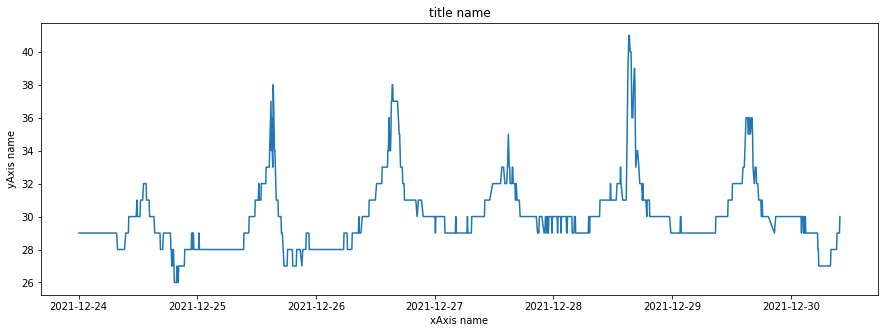

In [422]:
plt.plot(interpolateLinear_temperature.index,interpolateLinear_temperature.temperature)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [423]:
def interpolateHumidity(df):
  humidity = pd.DataFrame(df['humidity'])
  humidity.index = pd.to_datetime(df.index)
  humidity_interpolate = humidity.interpolate(method="linear")
  date = humidity.index
  interpolateLinear_humidity = pd.DataFrame(humidity_interpolate)
  return interpolateLinear_humidity
interpolateLinear_humidity = interpolateHumidity(df)

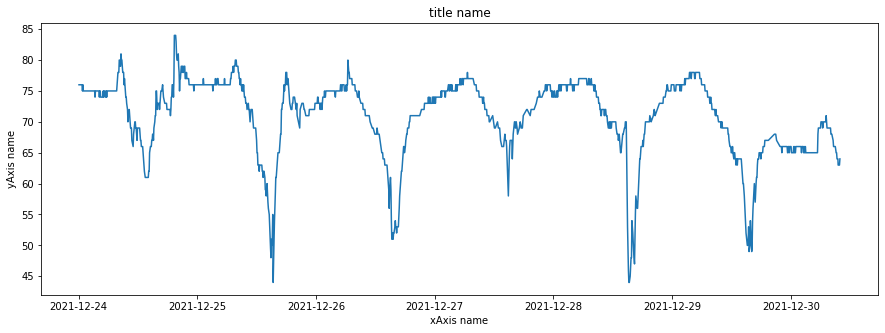

In [424]:
plt.plot(interpolateLinear_humidity.index,interpolateLinear_humidity.humidity)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [425]:
def interpolateUV(df):
  UV_index = pd.DataFrame(df['UV'])
  UV_index.index = pd.to_datetime(df.index)
  UV_index_interpolate = UV_index.interpolate(method="linear")
  date = UV_index.index
  interpolateLinear_UV_index = pd.DataFrame(UV_index_interpolate)
  return interpolateLinear_UV_index
interpolateLinear_UV_index = interpolateUV(df)

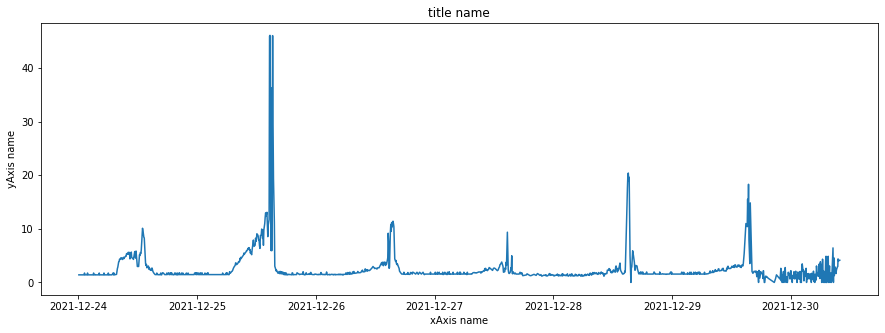

In [426]:
plt.plot(interpolateLinear_UV_index.index,interpolateLinear_UV_index.UV)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [427]:
rest = df[['CO2','CO', 'PM2.5']]
rest.index = pd.to_datetime(rest.index)

In [428]:
interpolate = pd.concat([rest, interpolateLinear_UV_index, interpolateLinear_temperature, interpolateLinear_humidity], axis = 1)

In [429]:
X = interpolate[["CO2", "CO", "PM2.5"]]
y = interpolate[["UV","temperature","humidity"]]

In [430]:
check_interpolate = interpolate.dropna()

In [431]:
check_interpolate

,CO2,CO,PM2.5,UV,temperature,humidity
2021-12-24 00:05:21,350.50281,6.85956,0.03028,1.41602,29.0,76.0
2021-12-24 00:10:38,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2021-12-24 00:15:54,350.50281,6.77918,0.02020,1.41602,29.0,76.0
2021-12-24 00:21:09,350.50281,6.69930,0.02860,1.41602,29.0,76.0
2021-12-24 00:26:28,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...
2021-12-30 09:35:13,439.89413,8.75908,0.00000,4.39453,29.0,63.0
2021-12-30 09:40:33,323.38361,7.71473,0.01852,4.00391,29.0,63.0
2021-12-30 09:45:55,323.38361,7.64320,0.01768,4.05273,29.0,63.0
2021-12-30 09:51:15,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [432]:
tipos2 = ['ascending', 'descending', 'roman', 'arabic', 'random']
resultado = []
for t in tipos2:
    iter_imputer=IterativeImputer(imputation_order=t)
    iter_imputer.fit(check_interpolate)
    X_iter= iter_imputer.transform(check_interpolate)

In [433]:
df_impute = pd.DataFrame(X_iter)
df_impute

,0,1,2,3,4,5
0,350.50281,6.85956,0.03028,1.41602,29.0,76.0
1,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2,350.50281,6.77918,0.02020,1.41602,29.0,76.0
3,350.50281,6.69930,0.02860,1.41602,29.0,76.0
4,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...
1423,439.89413,8.75908,0.00000,4.39453,29.0,63.0
1424,323.38361,7.71473,0.01852,4.00391,29.0,63.0
1425,323.38361,7.64320,0.01768,4.05273,29.0,63.0
1426,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [434]:
from time import time

In [435]:
percentage = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

result_r2_CO2 = []
result_mae_CO2 = []
result_rmse_CO2 = []

result_r2_CO = []
result_mae_CO = []
result_rmse_CO = []

result_r2_PM = []
result_mae_PM = []
result_rmse_PM = []

second_list = []

for i in percentage:
  mean_CO2_r2 = []
  mean_CO_r2 = []
  mean_PM_r2 = []

  mean_CO2_mae = []
  mean_CO_mae = []
  mean_PM_mae = []

  mean_CO2_rmse = []
  mean_CO_rmse = []
  mean_PM_rmse = []

  mean_second = []

  for t in range(1000):
    check = df_impute.sample(frac = i)
    other = df_impute.loc[df_impute.index.difference(check.index), ]
    check[0] = float("NaN")
    check[1] = float("NaN")
    check[2] = float("NaN")
    check = pd.concat([check, other]).sort_index()

    start_time = time()
    iter_imputer=IterativeImputer(imputation_order='roman')
    iter_imputer.fit(check)
    X_iter = iter_imputer.transform(check)
    end_time = time()
    seconds_elapsed = end_time - start_time

    performance = pd.DataFrame(X_iter)

    y0 = df_impute[0]
    y_pred0 = performance[0]
    y1 = df_impute[1]
    y_pred1 = performance[1]
    y2 = df_impute[2]
    y_pred2 = performance[2]

    r2_CO2 = metrics.r2_score(y0, y_pred0)
    mae_CO2 = metrics.mean_absolute_error(y0, y_pred0)
    RMSE_CO2 = np.sqrt(mean_squared_error(y0,y_pred0))

    r2_CO = metrics.r2_score(y1, y_pred1)
    mae_CO = metrics.mean_absolute_error(y1, y_pred1)
    RMSE_CO = np.sqrt(mean_squared_error(y1,y_pred1))

    r2_PM = metrics.r2_score(y2, y_pred2)
    mae_PM = metrics.mean_absolute_error(y2, y_pred2)
    RMSE_PM = np.sqrt(mean_squared_error(y2,y_pred2))

    mean_CO2_r2.append(r2_CO2)
    mean_CO_r2.append(r2_CO)
    mean_PM_r2.append(r2_PM)
    mean_CO2_mae.append(mae_CO2)
    mean_CO_mae.append(mae_CO)
    mean_PM_mae.append(mae_PM)
    mean_CO2_rmse.append(RMSE_CO2)
    mean_CO_rmse.append(RMSE_CO)
    mean_PM_rmse.append(RMSE_PM)

    mean_second.append(seconds_elapsed)
  
  result_r2_CO2.append(np.mean(mean_CO2_r2))
  result_r2_CO.append(np.mean(mean_CO_r2))
  result_r2_PM.append(np.mean(mean_PM_r2))
  result_rmse_CO2.append(np.mean(mean_CO2_rmse))
  result_rmse_CO.append(np.mean(mean_CO_rmse))
  result_rmse_PM.append(np.mean(mean_PM_rmse))
  result_mae_CO2.append(np.mean(mean_CO2_mae))
  result_mae_CO.append(np.mean(mean_CO_mae))
  result_mae_PM.append(np.mean(mean_PM_mae))
  second_list.append(np.mean(mean_second))

print(second_list)

[0.04888761711120605, 0.0497557122707367, 0.051341182947158816, 0.052621591806411745, 0.04944048404693604, 0.048130704164505]


In [437]:
print(result_r2_CO2)
print(result_rmse_CO2)
print(result_mae_CO2)
print(result_r2_CO)
print(result_rmse_CO)
print(result_mae_CO)
print(result_r2_PM)
print(result_rmse_PM)
print(result_mae_PM)

[0.9536661114522484, 0.9065677748153228, 0.8140894182503653, 0.7208853563557243, 0.627696013450909, 0.5331992826949995]
[10.221277492363333, 14.577869044066782, 20.62515957220047, 25.29286754586409, 29.22959987913213, 32.738756074665474]
[1.7667953893445003, 3.551336575060988, 7.089036555075067, 10.616453356801806, 14.178805479338044, 17.727030192782166]
[0.9532031001597925, 0.9056021156908357, 0.8116199431526367, 0.7174390874616943, 0.6224303299449448, 0.5273225337066649]
[0.23311040832815363, 0.3317329612168036, 0.4690978483857258, 0.5746660658452352, 0.6643981400952239, 0.7434504304402891]
[0.040104445304907074, 0.08089056446859162, 0.1615841407395295, 0.24188666993278884, 0.3234149789370168, 0.4042931324513778]
[0.9515316770557882, 0.9018544822994721, 0.80303225885406, 0.707129936910344, 0.6083612161339752, 0.5107916328854865]
[0.0023710262899969176, 0.0033912050455913493, 0.004825324217193705, 0.005893127880927127, 0.006819962970791902, 0.007625639382921863]
[0.0003981738428302115

In [436]:
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
in_seq1 = array([x for x in interpolate.CO2])
in_seq2 = array([x for x in interpolate.CO])
in_seq3 = array([x for x in interpolate['PM2.5']])
in_seq4 = array([x for x in interpolate.UV])
in_seq5 = array([x for x in interpolate.temperature])
in_seq6 = array([x for x in interpolate.humidity])
# out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i]+in_seq4[i]+in_seq5[i]+in_seq6[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
df1 = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))

In [438]:
def impute_em(X, max_iter = 3000, eps = 1e-08):
    '''(np.array, int, number) -> {str: np.array or int}
    
    Precondition: max_iter >= 1 and eps > 0
    
    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using 
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''
    
    nr, nc = X.shape
    C = np.isnan(X) == False
    
    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1
    
    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))
    
    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1
    
    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }
    
    return result

In [439]:
result_imputed = impute_em(check_interpolate.values)
result_imputed

{'C': array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]),
 'Sigma': array([[ 2.29896377e+03,  1.34843669e+01, -2.30186543e-02,
          6.79375313e+00, -1.29885727e+01, -5.56745962e+00],
        [ 1.34843669e+01,  1.16977678e+00, -2.29984660e-04,
         -7.46933953e-01, -4.16478207e-01,  1.51036524e+00],
        [-2.30186543e-02, -2.29984660e-04,  1.19127111e-04,
          4.44032957e-03,  1.98182217e-03, -1.73701782e-03],
        [ 6.79375313e+00, -7.46933953e-01,  4.44032957e-03,
          1.05639083e+01,  3.00878734e+00, -1.01565800e+01],
        [-1.29885727e+01, -4.16478207e-01,  1.98182217e-03,
          3.00878734e+00,  3.99257154e+00, -1.02787595e+01],
        [-5.56745962e+00,  1.51036524e+00, -1.73701782

In [440]:
df_EM = pd.DataFrame(result_imputed['X_imputed'])
df_EM

,0,1,2,3,4,5
0,350.50281,6.85956,0.03028,1.41602,29.0,76.0
1,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2,350.50281,6.77918,0.02020,1.41602,29.0,76.0
3,350.50281,6.69930,0.02860,1.41602,29.0,76.0
4,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...
1423,439.89413,8.75908,0.00000,4.39453,29.0,63.0
1424,323.38361,7.71473,0.01852,4.00391,29.0,63.0
1425,323.38361,7.64320,0.01768,4.05273,29.0,63.0
1426,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [ ]:
percentage = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

result_r2_CO2 = []
result_mae_CO2 = []
result_rmse_CO2 = []

result_r2_CO = []
result_mae_CO = []
result_rmse_CO = []

result_r2_PM = []
result_mae_PM = []
result_rmse_PM = []
second_list = []

for i in percentage:
  mean_CO2_r2 = []
  mean_CO_r2 = []
  mean_PM_r2 = []

  mean_CO2_mae = []
  mean_CO_mae = []
  mean_PM_mae = []

  mean_CO2_rmse = []
  mean_CO_rmse = []
  mean_PM_rmse = []

  mean_second = []
  for t in range(10):
    print(t)
    check = df_EM.sample(frac = i)
    other = df_EM.loc[df_EM.index.difference(check.index), ]
    check[0] = float("NaN")
    check[1] = float("NaN")
    check[2] = float("NaN")
    check = pd.concat([check, other]).sort_index()

    start_time = time()
    check_imputed = impute_em(check.values)
    check_EM = pd.DataFrame(check_imputed['X_imputed'])
    end_time = time()

    seconds_elapsed = end_time - start_time

    y0 = df_EM[0]
    y_pred0 = check_EM[0]
    y1 = df_EM[1]
    y_pred1 = check_EM[1]
    y2 = df_EM[2]
    y_pred2 = check_EM[2]

    r2_CO2 = metrics.r2_score(y0, y_pred0)
    mae_CO2 = metrics.mean_absolute_error(y0, y_pred0)
    RMSE_CO2 = np.sqrt(mean_squared_error(y0,y_pred0))

    r2_CO = metrics.r2_score(y1, y_pred1)
    mae_CO = metrics.mean_absolute_error(y1, y_pred1)
    RMSE_CO = np.sqrt(mean_squared_error(y1,y_pred1))

    r2_PM = metrics.r2_score(y2, y_pred2)
    mae_PM = metrics.mean_absolute_error(y2, y_pred2)
    RMSE_PM = np.sqrt(mean_squared_error(y2,y_pred2))

    mean_CO2_r2.append(r2_CO2)
    mean_CO_r2.append(r2_CO)
    mean_PM_r2.append(r2_PM)
    mean_CO2_mae.append(mae_CO2)
    mean_CO_mae.append(mae_CO)
    mean_PM_mae.append(mae_PM)
    mean_CO2_rmse.append(RMSE_CO2)
    mean_CO_rmse.append(RMSE_CO)
    mean_PM_rmse.append(RMSE_PM)

    mean_second.append(seconds_elapsed)
  
  result_r2_CO2.append(np.mean(mean_CO2_r2))
  result_r2_CO.append(np.mean(mean_CO_r2))
  result_r2_PM.append(np.mean(mean_PM_r2))

  result_rmse_CO2.append(np.mean(mean_CO2_rmse))
  result_rmse_CO.append(np.mean(mean_CO_rmse))
  result_rmse_PM.append(np.mean(mean_PM_rmse))

  result_mae_CO2.append(np.mean(mean_CO2_mae))
  result_mae_CO.append(np.mean(mean_CO_mae))
  result_mae_PM.append(np.mean(mean_PM_mae))

  second_list.append(np.mean(mean_second))

print(second_list)

In [442]:
print(result_r2_CO2)
print(result_rmse_CO2)
print(result_mae_CO2)
print(result_r2_CO)
print(result_rmse_CO)
print(result_mae_CO)
print(result_r2_PM)
print(result_rmse_PM)
print(result_mae_PM)

[0.9531987863150713, 0.9049644836955817, 0.8139689899136087, 0.7172189133672549, 0.6388518210182685, 0.5391088114805511]
[10.307730090206272, 14.733183618673397, 20.629150613369823, 25.47167561534035, 28.78374697149411, 32.53131056268292]
[1.7966136442382905, 3.555728363691968, 7.013254770986279, 10.762145043868035, 14.048576027390814, 17.659783531389774]
[0.950483017399924, 0.8984858358230777, 0.8170614751758739, 0.7233238717865254, 0.6262577804879315, 0.5354042436338806]
[0.24019430110750273, 0.3441980886766849, 0.46226060996030516, 0.5685217597934626, 0.6611765284359151, 0.737121109563676]
[0.0420152898376453, 0.08417840534538686, 0.1589239773968766, 0.23927406154276598, 0.3217728701178816, 0.4003159252286831]
[0.9464046563467108, 0.9072470399442801, 0.8035873120881101, 0.6987464810134978, 0.6161917741956813, 0.5330623372904892]
[0.002479092232158018, 0.0032926570742762623, 0.0048185612495710885, 0.005979478070721493, 0.00675306560068629, 0.007448468561157526]
[0.000409898127471545,

In [443]:
vecinos = [1,3,6]
resultado = []
for v in vecinos:
    KNN_imputer=KNNImputer(n_neighbors=v)
    KNN_imputer.fit(check_interpolate)
    X_knn= KNN_imputer.transform(check_interpolate)

In [444]:
df_KNN = pd.DataFrame(X_knn)
df_KNN

,0,1,2,3,4,5
0,350.50281,6.85956,0.03028,1.41602,29.0,76.0
1,350.50281,7.02184,0.02608,1.41602,29.0,76.0
2,350.50281,6.77918,0.02020,1.41602,29.0,76.0
3,350.50281,6.69930,0.02860,1.41602,29.0,76.0
4,350.50281,6.77918,0.02188,1.41602,29.0,76.0
...,...,...,...,...,...,...
1423,439.89413,8.75908,0.00000,4.39453,29.0,63.0
1424,323.38361,7.71473,0.01852,4.00391,29.0,63.0
1425,323.38361,7.64320,0.01768,4.05273,29.0,63.0
1426,323.38361,7.64320,0.01012,4.10156,29.0,63.0


In [445]:
percentage = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

result_r2_CO2 = []
result_mae_CO2 = []
result_rmse_CO2 = []

result_r2_CO = []
result_mae_CO = []
result_rmse_CO = []

result_r2_PM = []
result_mae_PM = []
result_rmse_PM = []
second_list = []

for i in percentage:
  mean_CO2_r2 = []
  mean_CO_r2 = []
  mean_PM_r2 = []

  mean_CO2_mae = []
  mean_CO_mae = []
  mean_PM_mae = []

  mean_CO2_rmse = []
  mean_CO_rmse = []
  mean_PM_rmse = []

  mean_second = []
  print(i)
  for t in range(100):
    check = df_KNN.sample(frac = i)
    other = df_KNN.loc[df_KNN.index.difference(check.index), ]
    check[0] = float("NaN")
    check[1] = float("NaN")
    check[2] = float("NaN")
    check = pd.concat([check, other]).sort_index()

    start_time = time()
    KNN_imputer=KNNImputer(n_neighbors=6)
    KNN_imputer.fit(check)
    X_knn= KNN_imputer.transform(check)
    end_time = time()

    seconds_elapsed = end_time - start_time

    performance = pd.DataFrame(X_knn)

    y0 = df_KNN[0]
    y_pred0 = performance[0]
    y1 = df_KNN[1]
    y_pred1 = performance[1]
    y2 = df_KNN[2]
    y_pred2 = performance[2]

    r2_CO2 = metrics.r2_score(y0, y_pred0)
    mae_CO2 = metrics.mean_absolute_error(y0, y_pred0)
    RMSE_CO2 = np.sqrt(mean_squared_error(y0,y_pred0))

    r2_CO = metrics.r2_score(y1, y_pred1)
    mae_CO = metrics.mean_absolute_error(y1, y_pred1)
    RMSE_CO = np.sqrt(mean_squared_error(y1,y_pred1))

    r2_PM = metrics.r2_score(y2, y_pred2)
    mae_PM = metrics.mean_absolute_error(y2, y_pred2)
    RMSE_PM = np.sqrt(mean_squared_error(y2,y_pred2))

    mean_CO2_r2.append(r2_CO2)
    mean_CO_r2.append(r2_CO)
    mean_PM_r2.append(r2_PM)
    mean_CO2_mae.append(mae_CO2)
    mean_CO_mae.append(mae_CO)
    mean_PM_mae.append(mae_PM)
    mean_CO2_rmse.append(RMSE_CO2)
    mean_CO_rmse.append(RMSE_CO)
    mean_PM_rmse.append(RMSE_PM)

    mean_second.append(seconds_elapsed)
  
  result_r2_CO2.append(np.mean(mean_CO2_r2))
  result_r2_CO.append(np.mean(mean_CO_r2))
  result_r2_PM.append(np.mean(mean_PM_r2))
  result_rmse_CO2.append(np.mean(mean_CO2_rmse))
  result_rmse_CO.append(np.mean(mean_CO_rmse))
  result_rmse_PM.append(np.mean(mean_PM_rmse))
  result_mae_CO2.append(np.mean(mean_CO2_mae))
  result_mae_CO.append(np.mean(mean_CO_mae))
  result_mae_PM.append(np.mean(mean_PM_mae))

  second_list.append(np.mean(mean_second))

0.05
0.1
0.2
0.3
0.4
0.5


In [446]:
print(result_r2_CO2)
print(result_rmse_CO2)
print(result_mae_CO2)

[0.962396137326663, 0.9172529055219728, 0.8337880742390729, 0.7534097781408424, 0.6750853463435259, 0.5895240363420998]
[9.196217522460813, 13.689894985515103, 19.50017748683894, 23.774176628852697, 27.30241178235214, 30.69523518694657]
[1.474030249486461, 3.0809220061041085, 6.198028974778245, 9.280354705753968, 12.325658152509336, 15.50068796532446]


In [447]:
print(result_r2_CO)
print(result_rmse_CO)
print(result_mae_CO)

[0.9699864693866571, 0.9386736932094792, 0.8768719449989254, 0.8135389785077749, 0.7493500926267727, 0.6722303542751675]
[0.18627172720918075, 0.26724320644543964, 0.37913834373365063, 0.4666938835638402, 0.5412147694428188, 0.6188334843787533]
[0.030941086169467794, 0.06299596966619983, 0.12639507012138188, 0.19027814917133515, 0.25658527328431374, 0.32888069066293185]


In [448]:
print(result_r2_PM)
print(result_rmse_PM)
print(result_mae_PM)

[0.9511493352987174, 0.8996838558168389, 0.8012494636758349, 0.7024992836909263, 0.6103620427534413, 0.503507437538407]
[0.0023875369641101077, 0.0034336496474768434, 0.004849015609879154, 0.005940726250855688, 0.0068038458797469396, 0.007684364854717082]
[0.0004077194444444444, 0.0008217519491129788, 0.001623245226423903, 0.0024433229341736694, 0.003244104014939309, 0.004076804225023343]


In [449]:
def imputation_KNN(df):
  KNN_imputer=KNNImputer(n_neighbors=6)
  KNN_imputer.fit(df)
  X_knn= KNN_imputer.transform(df)
  performance = pd.DataFrame(X_knn)
  df1 = df.reset_index()
  result = pd.concat([df1, performance[[0,1,2]]], axis=1)
  result = result.drop(columns=['CO2', 'CO', 'PM2.5'])
  result = result.rename({0: 'CO2', 1: 'CO', 2: 'PM2.5'}, axis=1)
  result.index = result['index']
  result.index.name = None
  return result

In [450]:
result = imputation_KNN(interpolate)

In [451]:
result.isnull().sum()

index          0
UV             0
temperature    0
humidity       0
CO2            0
CO             0
PM2.5          0
dtype: int64

DETECT OUTLIERS


In [452]:
import statsmodels.tsa.api as tsa

In [453]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [454]:
occ_data = result
occ_data = occ_data.set_index(result.index)
occ_data = occ_data.drop(columns=['index'])

In [455]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
preprocessed_data = differencing(occ_data, 'CO2', 288)
preprocessed_data1 = differencing(occ_data, 'CO', 288)
preprocessed_data2 = differencing(occ_data, 'PM2.5', 288)
preprocessed_data3 = differencing(occ_data, 'UV', 288)
preprocessed_data4 = differencing(occ_data, 'temperature', 288)
preprocessed_data5 = differencing(occ_data, 'humidity', 288)

In [456]:
print(test_stationarity(preprocessed_data, series=True))
print(test_stationarity(preprocessed_data1, series=True))
print(test_stationarity(preprocessed_data2, series=True))
print(test_stationarity(preprocessed_data3, series=True))
print(test_stationarity(preprocessed_data4, series=True))
print(test_stationarity(preprocessed_data5, series=True))

Stationary
Stationary
Stationary
Stationary
Stationary
Stationary


In [457]:
import statsmodels.tsa.api as tsa
from joblib import Parallel, delayed

In [458]:
max_p, max_q = 5, 5 
def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets
def find_aic_for_model(data, p, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, q)
        ts_results = model(data, order=(p, q)).fit(disp=False)
        curr_aic = ts_results.aic
        return curr_aic, (p, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, q)
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, 1)).fit(disp=False)
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = Parallel(n_jobs=len(order_set), prefer='threads')(
                delayed(find_aic_for_model)(data, p, q, model, model_name)
                for q in order_set
            )
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df
min_aic, min_order, results_df = find_best_order_for_model(
    preprocessed_data, tsa.ARMA, "ARMA"
)
min_aic1, min_order1, results_df1 = find_best_order_for_model(
    preprocessed_data1, tsa.ARMA, "ARMA"
)
min_aic2, min_order2, results_df2 = find_best_order_for_model(
    preprocessed_data2, tsa.ARMA, "ARMA"
)
min_aic3, min_order3, results_df3 = find_best_order_for_model(
    preprocessed_data3, tsa.ARMA, "ARMA"
)
min_aic4, min_order4, results_df4 = find_best_order_for_model(
    preprocessed_data4, tsa.ARMA, "ARMA"
)
min_aic5, min_order5, results_df5 = find_best_order_for_model(
    preprocessed_data5, tsa.ARMA, "ARMA"
)
print(min_aic, min_order)
print(min_aic1, min_order1)
print(min_aic2, min_order2)
print(min_aic3, min_order3)
print(min_aic4, min_order4)
print(min_aic5, min_order5)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)nFitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n

Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)n
Fitting ARMA with order p, q = (1, 1)nFitting ARMA with order p, q = (1, 2)n

Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (2, 0)n
Fitting ARMA with order p, q = (2, 1)n
Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)nFitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)nFitting ARMA with order p, q = (4, 1)nFitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n


Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)n
Fitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n
Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)nFitting ARMA with order p, q = (1, 1)nFitting ARMA with order p, q = (1, 2)n
Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (2, 0)n
Fitting ARMA with order p, q = (2, 1)n
Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)n
Fitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)n
Fitting ARMA with order p, q = (4, 1)n
Fitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)n
Fitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n
Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)n
Fitting ARMA with order p, q = (1, 1)n
Fitting ARMA with order p, q = (1, 2)n
Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (2, 0)nFitting ARMA with order p, q = (2, 1)n
Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)n
Fitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)n
Fitting ARMA with order p, q = (4, 1)n
Fitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)n
Fitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)nFitting ARMA with order p, q = (0, 3)n

Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)nFitting ARMA with order p, q = (1, 1)nFitting ARMA with order p, q = (1, 2)n


Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (2, 0)nFitting ARMA with order p, q = (2, 1)n

Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)n
Fitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)n
Fitting ARMA with order p, q = (4, 1)n
Fitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)nFitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n

Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)nFitting ARMA with order p, q = (1, 1)n

Fitting ARMA with order p, q = (1, 2)n
Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n
Fitting ARMA with order p, q = (2, 0)n
Fitting ARMA with order p, q = (2, 1)n
Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)nFitting ARMA with order p, q = (3, 1)n
Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n

Fitting ARMA with order p, q = (3, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)nFitting ARMA with order p, q = (4, 1)n

Fitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (0, 0)nFitting ARMA with order p, q = (0, 1)n
Fitting ARMA with order p, q = (0, 2)n

Fitting ARMA with order p, q = (0, 3)n
Fitting ARMA with order p, q = (0, 4)n
Fitting ARMA with order p, q = (1, 0)n
Fitting ARMA with order p, q = (1, 1)n
Fitting ARMA with order p, q = (1, 2)n
Fitting ARMA with order p, q = (1, 3)n
Fitting ARMA with order p, q = (1, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (2, 0)n
Fitting ARMA with order p, q = (2, 1)n
Fitting ARMA with order p, q = (2, 2)n
Fitting ARMA with order p, q = (2, 3)n
Fitting ARMA with order p, q = (2, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (3, 0)nFitting ARMA with order p, q = (3, 1)n

Fitting ARMA with order p, q = (3, 2)n
Fitting ARMA with order p, q = (3, 3)n
Fitting ARMA with order p, q = (3, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

Fitting ARMA with order p, q = (4, 0)n
Fitting ARMA with order p, q = (4, 1)n
Fitting ARMA with order p, q = (4, 2)n
Fitting ARMA with order p, q = (4, 3)n
Fitting ARMA with order p, q = (4, 4)n


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

17716.535393942708 (4, 4)
3369.905513949824 (2, 1)
-10281.05294086255 (3, 4)
7812.331592933942 (4, 4)
2483.910487065031 (4, 2)
5213.566703939514 (2, 3)


In [459]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [460]:
arma = tsa.ARMA(preprocessed_data, order=min_order)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [461]:
arma = tsa.ARMA(preprocessed_data1, order=min_order1)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions1, threshold1 = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [462]:
arma = tsa.ARMA(preprocessed_data2, order=min_order2)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions2, threshold2 = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [463]:
arma = tsa.ARMA(preprocessed_data3, order=min_order3)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions3, threshold3 = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [464]:
arma = tsa.ARMA(preprocessed_data4, order=min_order4)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions4, threshold4 = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [465]:
arma = tsa.ARMA(preprocessed_data5, order=min_order5)
arma_fit = arma.fit()
squared_errors = arma_fit.resid ** 2
predictions5, threshold5 = find_anomalies(squared_errors) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [466]:
occ_data['predictions'] = predictions
occ_data['predictions1'] = predictions1
occ_data['predictions2'] = predictions2
occ_data['predictions3'] = predictions3
occ_data['predictions4'] = predictions4
occ_data['predictions5'] = predictions5

occ_data

,UV,temperature,humidity,CO2,CO,PM2.5,predictions,predictions1,predictions2,predictions3,predictions4,predictions5
2021-12-24 00:05:21,1.41602,29.0,76.0,350.50281,6.85956,0.03028,0,0,0,0,0,0
2021-12-24 00:10:38,1.41602,29.0,76.0,350.50281,7.02184,0.02608,0,0,0,0,0,0
2021-12-24 00:15:54,1.41602,29.0,76.0,350.50281,6.77918,0.02020,0,0,0,0,0,0
2021-12-24 00:21:09,1.41602,29.0,76.0,350.50281,6.69930,0.02860,0,0,0,0,0,0
2021-12-24 00:26:28,1.41602,29.0,76.0,350.50281,6.77918,0.02188,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 09:35:13,4.39453,29.0,63.0,439.89413,8.75908,0.00000,1,0,0,0,0,0
2021-12-30 09:40:33,4.00391,29.0,63.0,323.38361,7.71473,0.01852,0,1,0,0,0,0
2021-12-30 09:45:55,4.05273,29.0,63.0,323.38361,7.64320,0.01768,0,0,0,0,0,0
2021-12-30 09:51:15,4.10156,29.0,63.0,323.38361,7.64320,0.01012,0,0,0,0,0,0


In [467]:
print(occ_data['predictions'].value_counts())
print(occ_data['predictions1'].value_counts())
print(occ_data['predictions2'].value_counts())
print(occ_data['predictions3'].value_counts())
print(occ_data['predictions4'].value_counts())
print(occ_data['predictions5'].value_counts())

0    1609
1      90
Name: predictions, dtype: int64
0    1523
1     176
Name: predictions1, dtype: int64
0    1627
1      72
Name: predictions2, dtype: int64
0    1681
1      18
Name: predictions3, dtype: int64
0    1647
1      52
Name: predictions4, dtype: int64
0    1632
1      67
Name: predictions5, dtype: int64


In [468]:
occ_data.loc[occ_data["predictions"] == 1, "CO2"] = float('NaN')
occ_data.loc[occ_data["predictions1"] == 1, "CO"] = float('NaN')
occ_data.loc[occ_data["predictions2"] == 1, "PM2.5"] = float('NaN')
occ_data.loc[occ_data["predictions3"] == 1, "UV"] = float('NaN')
occ_data.loc[occ_data["predictions4"] == 1, "temperature"] = float('NaN')
occ_data.loc[occ_data["predictions5"] == 1, "humidity"] = float('NaN')

occ_data.isnull().sum()

UV               18
temperature      52
humidity         67
CO2              90
CO              176
PM2.5            72
predictions       0
predictions1      0
predictions2      0
predictions3      0
predictions4      0
predictions5      0
dtype: int64

In [469]:
def fill_missing(df):
  UV_outlier = interpolateUV(df)
  temperature_outlier = interpolateHumidity(df)
  humidity_outlier = interpolateTemperature(df)
  pollutants = df[['CO2','CO', 'PM2.5']]
  pollutants.index = pd.to_datetime(pollutants.index)
  pollutants_fill = pd.concat([pollutants, UV_outlier, temperature_outlier, humidity_outlier], axis = 1)
  result_outlier = imputation_KNN(pollutants_fill)
  return result_outlier

In [470]:
result_outlier = fill_missing(occ_data)

In [471]:
result_outlier.isnull().sum()

index          0
UV             0
humidity       0
temperature    0
CO2            0
CO             0
PM2.5          0
dtype: int64

In [472]:
result_outlier

,index,UV,humidity,temperature,CO2,CO,PM2.5
2021-12-24 00:05:21,2021-12-24 00:05:21,1.41602,76.0,29.0,350.502810,6.859560,0.03028
2021-12-24 00:10:38,2021-12-24 00:10:38,1.41602,76.0,29.0,350.502810,7.021840,0.02608
2021-12-24 00:15:54,2021-12-24 00:15:54,1.41602,76.0,29.0,350.502810,6.779180,0.02020
2021-12-24 00:21:09,2021-12-24 00:21:09,1.41602,76.0,29.0,350.502810,6.699300,0.02860
2021-12-24 00:26:28,2021-12-24 00:26:28,1.41602,76.0,29.0,350.502810,6.779180,0.02188
...,...,...,...,...,...,...,...
2021-12-30 09:35:13,2021-12-30 09:35:13,4.39453,63.0,29.0,328.452995,8.759080,0.00000
2021-12-30 09:40:33,2021-12-30 09:40:33,4.00391,63.0,29.0,323.383610,7.778919,0.01852
2021-12-30 09:45:55,2021-12-30 09:45:55,4.05273,63.0,29.0,323.383610,7.643200,0.01768
2021-12-30 09:51:15,2021-12-30 09:51:15,4.10156,63.0,29.0,323.383610,7.643200,0.01012


In [473]:
result_outlier = result_outlier.drop(columns=['index'])

In [474]:
result_outlier

,UV,humidity,temperature,CO2,CO,PM2.5
2021-12-24 00:05:21,1.41602,76.0,29.0,350.502810,6.859560,0.03028
2021-12-24 00:10:38,1.41602,76.0,29.0,350.502810,7.021840,0.02608
2021-12-24 00:15:54,1.41602,76.0,29.0,350.502810,6.779180,0.02020
2021-12-24 00:21:09,1.41602,76.0,29.0,350.502810,6.699300,0.02860
2021-12-24 00:26:28,1.41602,76.0,29.0,350.502810,6.779180,0.02188
...,...,...,...,...,...,...
2021-12-30 09:35:13,4.39453,63.0,29.0,328.452995,8.759080,0.00000
2021-12-30 09:40:33,4.00391,63.0,29.0,323.383610,7.778919,0.01852
2021-12-30 09:45:55,4.05273,63.0,29.0,323.383610,7.643200,0.01768
2021-12-30 09:51:15,4.10156,63.0,29.0,323.383610,7.643200,0.01012


In [475]:
result_outlier = result_outlier.reindex(['CO2', 'CO', 'PM2.5','UV','temperature','humidity'], axis=1)

Forecasting

In [516]:
data = pd.read_csv('/content/preprocessing.csv')

In [517]:
data.index = data['Unnamed: 0']
data.index.name = None
data

,Unnamed: 0,CO2,CO,PM2.5,UV,temperature,humidity
11/29/2021 12:06,11/29/2021 12:06,679.165890,8.670000,0.000000,6.73828,30.0,74.000000
11/29/2021 12:12,11/29/2021 12:12,581.378170,8.493380,0.004240,6.44531,30.0,73.000000
11/29/2021 12:17,11/29/2021 12:17,657.984680,8.848690,0.014320,5.71289,30.0,74.000000
11/29/2021 12:22,11/29/2021 12:22,661.938780,8.848690,0.002560,5.66406,30.0,73.000000
11/29/2021 12:28,11/29/2021 12:28,611.186767,8.895212,0.011925,5.58268,30.0,73.333333
...,...,...,...,...,...,...,...
1/15/2022 7:58,1/15/2022 7:58,1633.276000,8.422690,0.062190,3.32031,29.0,69.000000
1/15/2022 8:03,1/15/2022 8:03,1386.610220,8.759080,0.068070,3.12500,29.0,68.000000
1/15/2022 8:09,1/15/2022 8:09,461.922628,9.971180,0.056310,3.80859,29.0,69.000000
1/15/2022 8:14,1/15/2022 8:14,1407.696682,8.827430,0.041190,3.32031,28.0,69.000000


In [518]:
data = data.drop(columns=['Unnamed: 0'])
data

,CO2,CO,PM2.5,UV,temperature,humidity
11/29/2021 12:06,679.165890,8.670000,0.000000,6.73828,30.0,74.000000
11/29/2021 12:12,581.378170,8.493380,0.004240,6.44531,30.0,73.000000
11/29/2021 12:17,657.984680,8.848690,0.014320,5.71289,30.0,74.000000
11/29/2021 12:22,661.938780,8.848690,0.002560,5.66406,30.0,73.000000
11/29/2021 12:28,611.186767,8.895212,0.011925,5.58268,30.0,73.333333
...,...,...,...,...,...,...
1/15/2022 7:58,1633.276000,8.422690,0.062190,3.32031,29.0,69.000000
1/15/2022 8:03,1386.610220,8.759080,0.068070,3.12500,29.0,68.000000
1/15/2022 8:09,461.922628,9.971180,0.056310,3.80859,29.0,69.000000
1/15/2022 8:14,1407.696682,8.827430,0.041190,3.32031,28.0,69.000000


Unvariate LSTM

In [519]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [520]:
from sklearn.preprocessing import MinMaxScaler

In [521]:
sc = MinMaxScaler()

In [522]:
from datetime import datetime

In [527]:
data = data.reset_index()

In [528]:
year = []
month = []
day = []
hour = [] 
minutes = []
for i in range(len(data['index'])):
  time = datetime.strptime(str(data['index'][i]), "%m/%d/%Y %H:%M")
  year.append(time.year)
  month.append(time.month)
  day.append(time.day)
  hour.append(time.hour)
  minutes.append(time.minute)
data['year'] = pd.DataFrame(year)[0]
data['month'] = pd.DataFrame(month)[0]
data['day'] = pd.DataFrame(day)[0]
data['hour'] = pd.DataFrame(hour)[0]
data['minute'] = pd.DataFrame(minutes)[0]

In [531]:
for i in range(len(data['minute'])):
  mode = data['minute'][i]%5
  if (mode == 0):
    data['minute'][i] = data['minute'][i]
  else:
    data['minute'][i] = data['minute'][i] - mode

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [533]:
data = data.groupby(['year', 'month','day','hour']).agg(
    {
         'CO': 'mean',  
         'PM2.5': 'mean', 
         'UV': 'mean',
         'humidity': 'mean',
         'temperature': 'mean',
         'CO2':'mean'
    }
)
data

CO     PM2.5  ...  temperature          CO2
year month day hour                      ...                          
2021 11    29  12    8.802094  0.007469  ...    29.966190   618.911933
               13    7.549675  0.006123  ...    29.568686   348.346306
               14    8.978705  0.010575  ...    29.090909   263.042976
               15    9.324015  0.006823  ...    29.583333   269.476606
               16    9.564733  0.003455  ...    29.454545   278.668723
...                       ...       ...  ...          ...          ...
2022 1     15  4     7.866719  0.031117  ...    29.750000  1400.129008
               5     8.252700  0.039514  ...    29.363636  1388.751564
               6     8.530951  0.053409  ...    29.000000  1379.844712
               7     8.713757  0.054491  ...    29.000000  1358.280148
               8     8.995095  0.058200  ...    28.500000   865.618849

[749 rows x 6 columns]

In [534]:
data = data.reset_index()
data

,year,month,day,hour,CO,PM2.5,UV,humidity,temperature,CO2
0,2021,11,29,12,8.802094,0.007469,5.668500,73.363636,29.966190,618.911933
1,2021,11,29,13,7.549675,0.006123,4.459637,74.291667,29.568686,348.346306
2,2021,11,29,14,8.978705,0.010575,3.062855,75.636364,29.090909,263.042976
3,2021,11,29,15,9.324015,0.006823,3.019207,76.666667,29.583333,269.476606
4,2021,11,29,16,9.564733,0.003455,1.970879,76.181818,29.454545,278.668723
...,...,...,...,...,...,...,...,...,...,...
744,2022,1,15,4,7.866719,0.031117,2.506508,67.666667,29.750000,1400.129008
745,2022,1,15,5,8.252700,0.039514,2.570135,67.909091,29.363636,1388.751564
746,2022,1,15,6,8.530951,0.053409,2.579010,69.363636,29.000000,1379.844712
747,2022,1,15,7,8.713757,0.054491,2.795410,69.416667,29.000000,1358.280148


In [535]:
data['minute'] = str("00")
data['second'] = str("00")

In [536]:
cols = ['hour', 'minute', 'second']
data['time'] = data[cols].apply(lambda x: ':'.join(x.values.astype(str)), axis="columns")

In [537]:
for i in range(len(data['time'])):
  if (len(data['time'][i]) == 7):
    data['time'][i] = "0" + data['time'][i][0:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [538]:
cols = ['year', 'month', 'day']
data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [539]:
data['date'] = pd.to_datetime(data['date'] + " "+ data['time'])

In [540]:
data.index = data['date']
data.index.name = None

In [541]:
temperature = data['temperature']
temperature.index = data.index
temperature = pd.DataFrame(temperature)

In [542]:
temperature

,temperature
2021-11-29 12:00:00,29.966190
2021-11-29 13:00:00,29.568686
2021-11-29 14:00:00,29.090909
2021-11-29 15:00:00,29.583333
2021-11-29 16:00:00,29.454545
...,...
2022-01-15 04:00:00,29.750000
2022-01-15 05:00:00,29.363636
2022-01-15 06:00:00,29.000000
2022-01-15 07:00:00,29.000000


In [543]:
scale = pd.DataFrame(sc.fit_transform(temperature), index=temperature.index, columns=temperature.columns)
scale

,temperature
2021-11-29 12:00:00,0.243390
2021-11-29 13:00:00,0.215107
2021-11-29 14:00:00,0.181113
2021-11-29 15:00:00,0.216149
2021-11-29 16:00:00,0.206986
...,...
2022-01-15 04:00:00,0.228008
2022-01-15 05:00:00,0.200517
2022-01-15 06:00:00,0.174644
2022-01-15 07:00:00,0.174644


In [553]:
deep_learner = DeepModelTS(
    data = scale,
    Y_var = 'temperature',
    lag = 24,
    LSTM_layer_depth=64,
    epochs=200,
    train_test_split=0.1
)

In [554]:
model = deep_learner.LSTModel()

Epoch 1/200
3/3 [==============================] - 2s 160ms/step - loss: 0.0621 - val_loss: 0.0684
Epoch 2/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0482 - val_loss: 0.0512
Epoch 3/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0353 - val_loss: 0.0357
Epoch 4/200
3/3 [==============================] - 0s 54ms/step - loss: 0.0240 - val_loss: 0.0223
Epoch 5/200
3/3 [==============================] - 0s 52ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 6/200
3/3 [==============================] - 0s 55ms/step - loss: 0.0163 - val_loss: 0.0190
Epoch 7/200
3/3 [==============================] - 0s 51ms/step - loss: 0.0189 - val_loss: 0.0172
Epoch 8/200
3/3 [==============================] - 0s 50ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 9/200
3/3 [==============================] - 0s 53ms/step - loss: 0.0146 - val_loss: 0.0167
Epoch 10/200
3/3 [==============================] - 0s 56ms/step - loss: 0.0146 - val_loss: 0.0176
Epoch 11/200
3/3 [

In [555]:
yhat = deep_learner.predict()

In [556]:
tdf = pd.DataFrame(sc.inverse_transform(scale), index=temperature.index, columns=temperature.columns)
yhat = pd.DataFrame(yhat)

In [557]:
yhat = sc.inverse_transform(yhat)

In [558]:
if len(yhat) > 0:
  fc = temperature.tail(len(yhat)).copy()
  fc.reset_index(inplace=True)
  fc['forecast'] = yhat

In [551]:
def plot(y1,y2,title,file_name):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('') 
    # giving a title to my graph 
    plt.title(title) 
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    
    plt.savefig(file_name,dpi=1200)
    plt.show()

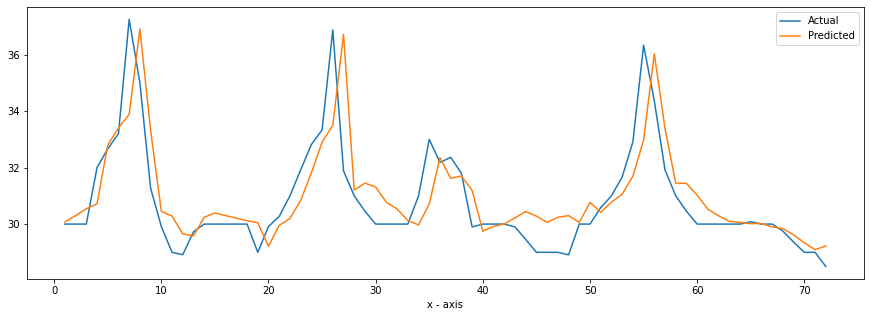

In [559]:
plot(fc['temperature'], fc['forecast'], "", "")

In [560]:
r2 = metrics.r2_score(fc['temperature'], fc['forecast'])
mae = metrics.mean_absolute_error(fc['temperature'], fc['forecast'])
RMSE = np.sqrt(mean_squared_error(fc['temperature'], fc['forecast']))

In [561]:
r2, mae, RMSE

(0.5635952931471175, 0.8092740851863138, 1.2084928060377318)

In [ ]:
fc = temperature.copy() 
fc

,humidity
2021-11-29 12:00:00,73.363636
2021-11-29 13:00:00,74.291667
2021-11-29 14:00:00,75.636364
2021-11-29 15:00:00,76.666667
2021-11-29 16:00:00,76.181818
...,...
2022-01-15 04:00:00,67.666667
2022-01-15 05:00:00,67.909091
2022-01-15 06:00:00,69.363636
2022-01-15 07:00:00,69.416667


In [ ]:
yhat = deep_learner.predict_n_ahead(24)

In [ ]:
yhat

[array([[0.6364244]], dtype=float32),
 array([[0.6091483]], dtype=float32),
 array([[0.5795655]], dtype=float32),
 array([[0.55078304]], dtype=float32),
 array([[0.5220533]], dtype=float32),
 array([[0.49632683]], dtype=float32),
 array([[0.47754845]], dtype=float32),
 array([[0.4672939]], dtype=float32),
 array([[0.46713597]], dtype=float32),
 array([[0.4791101]], dtype=float32),
 array([[0.4979546]], dtype=float32),
 array([[0.5195067]], dtype=float32),
 array([[0.5401083]], dtype=float32),
 array([[0.5588287]], dtype=float32),
 array([[0.5756664]], dtype=float32),
 array([[0.59183556]], dtype=float32),
 array([[0.6078415]], dtype=float32),
 array([[0.624472]], dtype=float32),
 array([[0.64180726]], dtype=float32),
 array([[0.65879077]], dtype=float32),
 array([[0.6740292]], dtype=float32),
 array([[0.6862611]], dtype=float32),
 array([[0.69234604]], dtype=float32),
 array([[0.6902898]], dtype=float32)]

In [ ]:
yhat = [y[0][0] for y in yhat]

In [ ]:
yhat = np.asarray(yhat)

In [ ]:
yhat = sc.inverse_transform(yhat.reshape(-1,1))
yhat = pd.DataFrame(yhat)
yhat

,0
0,67.476746
1,66.221992
2,64.861130
3,63.537083
4,62.215454
5,61.031990
6,60.168144
7,59.696419
8,59.689152
9,60.239983


In [ ]:
after = fc.reset_index()

In [ ]:
after = after.drop(columns=['index'])

In [ ]:
final = pd.concat([after, yhat])
final

,humidity,0
0,73.363636,NaN
1,74.291667,NaN
2,75.636364,NaN
3,76.666667,NaN
4,76.181818,NaN
...,...,...
19,NaN,68.505638
20,NaN,69.206635
21,NaN,69.769333
22,NaN,70.049248


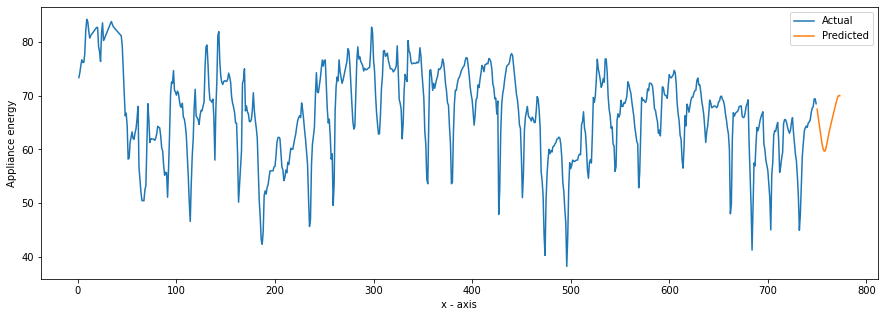

In [ ]:
plot(final['humidity'], final[0], "", "")

In [ ]:
yhat = deep_learner.predict_n_ahead(12)
yhat = [y[0][0] for y in yhat]
yhat = np.asarray(yhat)
yhat = sc.inverse_transform(yhat.reshape(-1,1))

In [ ]:
predict_CO2 = result_outlier.loc[:, ['date', 'temperature']]

Multivariate Forecasting

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
values = predict.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    print(pd.DataFrame(agg))
    return agg

In [ ]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 12)
    reframed.drop(reframed.loc[:, 'var2(t)':'var6(t)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+1)':'var6(t+1)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+2)':'var6(t+2)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+3)':'var6(t+3)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+4)':'var6(t+4)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+5)':'var6(t+5)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+6)':'var6(t+6)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+7)':'var6(t+7)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+8)':'var6(t+8)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+9)':'var6(t+9)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+10)':'var6(t+10)'], inplace = True, axis = 1)
    reframed.drop(reframed.loc[:, 'var2(t+11)':'var6(t+11)'], inplace = True, axis = 1)

    if flag==1 :
        print(pd.DataFrame(reframed))
    # split into train and test sets
    values = reframed.values
    # n_train = int(0.8*(len(data)))
    train = values[:95, :]
    test = values[95:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -12:]
    test_X, test_y = test[:, :n_obs], test[:, -12:]    
    print(train_X.shape, len(train_X), train_y.shape)
    print(test_X.shape, len(test_X), test_y.shape)
    return train_X, train_y, test_X, test_y

In [ ]:
def LinearReg(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [ ]:
# Implementing SVM method
def SVM_Gausian(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='rbf')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [ ]:
# Implementing SVM method
def SVM_Linear(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='linear')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [ ]:
# Implementing Lasso Regression method
def LassoRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Lasso()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [ ]:
# Implementing Lasso Regression method
def RidgeRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Ridge()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [ ]:
def LinearRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LinearReg(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [ ]:
def SVM_Gausian_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos

In [ ]:
def SVM_Linear_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos

In [ ]:
def LassoRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos

In [ ]:
def RidgeRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos

In [ ]:
def LinearRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=LinearReg(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos

In [ ]:
def SVM_Gausian_GSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos

In [ ]:
def SVM_Linear_GSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos

In [ ]:
def LassoRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=LassoRegression(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos

In [ ]:
def RidgeRegGSA(data,maxI,npop,g0,alpha,e,eps,n_features,m) :
    print()
    print("USING GSA")
    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))       
            self.cost=[]      
            self.bestcost=[] 
            self.worstcost=[]      
            self.bestposition=np.random.randint(1,m,(npop,n_features))
            self.mass=np.zeros((npop,n_features))
            self.force=np.zeros((npop,n_features))
            self.acc=np.zeros((npop,n_features))

    s1=Particle()
    Globalbest=2**10000
    Globalworst=-1
    Globalpos=[]
    for i in range(0,npop) :
        pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        s1.worstcost.append(mse)
        if mse<Globalbest :
            Globalbest=mse
            Globalpos=s1.position[i,:]
        if mse>Globalworst :
            Globalworst=mse
        

    #count=npop

    for it in range(0,maxI) :
        best = min(s1.cost)
        worst = max(s1.cost)
        total = 0
        for i in range(0,npop) :
            for j in range(0,n_features) :
                pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
                x=mse - worst
                s1.mass[i][j] = float(x/float(best - worst))
                total=total+s1.mass[i][j]+e
        kbest = int(npop - (npop-1)*((i+1)/float(maxI)))
        G = g0*((float((i+1)/float(maxI)))**alpha)
        #count = count + (kbest + 1)*npop
        for i in range(0,npop) :
            for j in range(0,n_features) :
                s = 0
                s1.mass[i][j] = float(s1.mass[i][j]/total)
                for k in range(0,kbest) :
                    if k!=i :
                        x = float(G*s1.mass[k][j]*(s1.position[k][j] - s1.position[i][j]))
                        y = float((s1.position[i][j] * s1.position[k][j]) + e)
                        f = float(random.uniform(0,1)*float(x/float(y)))
                        s=s+f
                s1.force[i][j]=float(s*s1.mass[i][j])
                s1.acc[i][j]=s
                s1.velocity[i][j] = random.uniform(0,1)*s1.velocity[i][j] + s1.acc[i][j]
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))
                pred,s1.cost[i],mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)

                if s1.cost[i] < s1.bestcost[i] :
                    s1.bestcost[i] = s1.cost[i]
                    s1.bestposition[i,:] = s1.position[i,:]
                    if s1.bestcost[i] < Globalbest :
                        Globalbest = s1.bestcost[i]
                        Globalpos = s1.bestposition[i,:] 

                if s1.cost[i] > s1.worstcost[i] :
                    s1.worstcost[i] = s1.cost[i]
                    if s1.worstcost[i] > Globalworst :
                        Globalworst = s1.worstcost[i]

        x = Globalpos
        y = Globalbest
        print("Iteration: " + str(it) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y))
    return Globalbest,Globalpos

In [ ]:
def plot(y1,y2,title,file_name):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('Appliance energy') 
    # giving a title to my graph 
    plt.title(title) 
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    
    plt.savefig(file_name,dpi=1200)
    plt.show()

In [ ]:
MSE = {}
MAE = {}

     var1(t-24)  var1(t-23)  var1(t-22)  ...  var4(t+11)  var5(t+11)  var6(t+11)
24     1.000000    0.274337    0.273975  ...    0.998178    0.982643    0.892882
25     0.274337    0.273975    0.273798  ...    0.998298    0.982717    0.892330
26     0.273975    0.273798    0.273962  ...    0.998501    0.982814    0.892124
27     0.273798    0.273962    0.274319  ...    0.999154    0.982908    0.891534
28     0.273962    0.274319    0.274072  ...    0.999588    0.982990    0.891596
..          ...         ...         ...  ...         ...         ...         ...
150    0.272710    0.273243    0.273229  ...    0.000000    0.000000    0.000000
151    0.273243    0.273229    0.273524  ...    0.000000    0.000000    0.000000
152    0.273229    0.273524    0.273003  ...    0.000000    0.000000    0.000000
153    0.273524    0.273003    0.272878  ...    0.000000    0.000000    0.000000
154    0.273003    0.272878    0.272731  ...    0.000000    0.000000    0.000000

[131 rows x 216 columns]
  

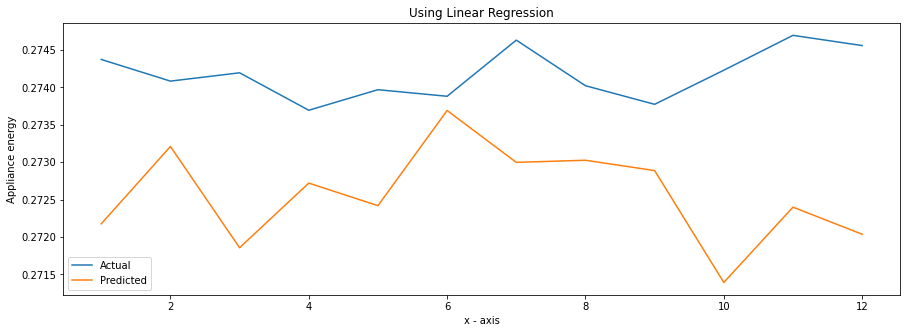

In [ ]:
n_lag = []
n_features = 6
for i in range(0,n_features):
    if i%2==0:
        n_lag.append(24)
    else:
        n_lag.append(24)
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(scaled, n_lag, n_features,1)
print(test[-13])

print("MSE for Linear Regression method: " + str(MSE['LinearRegression']))
print("MAE for Linear Regression method: " + str(MAE['LinearRegression']))
plot(test[-13], prediction[-13], 'Using Linear Regression','Linear Regression.png')

(1359, 1728) 1359 (1359,)
MSE for SVM_Gausian method: 0.012296669979617621
MAE for SVM_Gausian method: 0.08731647250863653


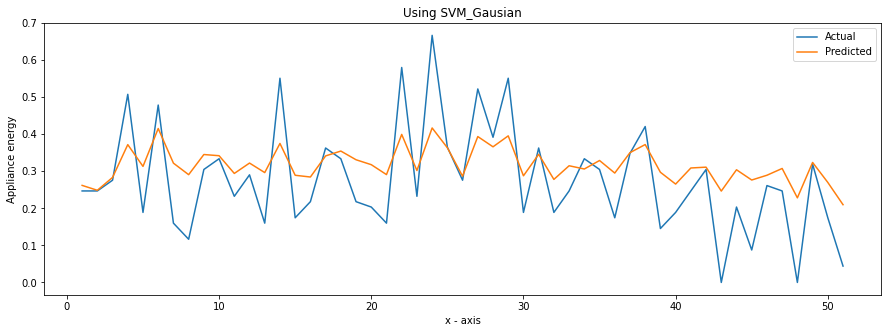

In [ ]:
prediction, MSE['SVM_Gausian'], MAE['SVM_Gausian'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian method: " + str(MSE['SVM_Gausian']))
print("MAE for SVM_Gausian method: " + str(MAE['SVM_Gausian']))
plot(test, prediction, 'Using SVM_Gausian','SVM_Gausian.png')

(1359, 1728) 1359 (1359,)
MSE for SVM_Linear method: 0.008615110389668067
MAE for SVM_Linear method: 0.0717453938438555


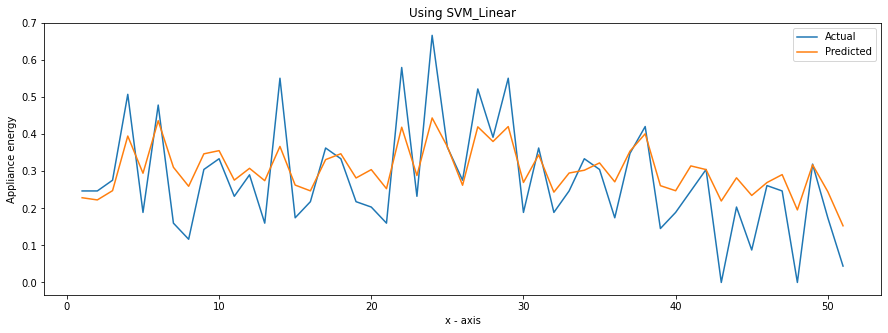

In [ ]:
# Call SVM Linear model
prediction, MSE['SVM_Linear'], MAE['SVM_Linear'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear method: " + str(MSE['SVM_Linear']))
print("MAE for SVM_Linear method: " + str(MAE['SVM_Linear']))
plot(test, prediction, 'Using SVM_Linear','SVM_Linear.png')

(1359, 1728) 1359 (1359,)
MSE for Lasso Regression method: 0.02905112
MAE for Lasso Regression method: 0.14545971


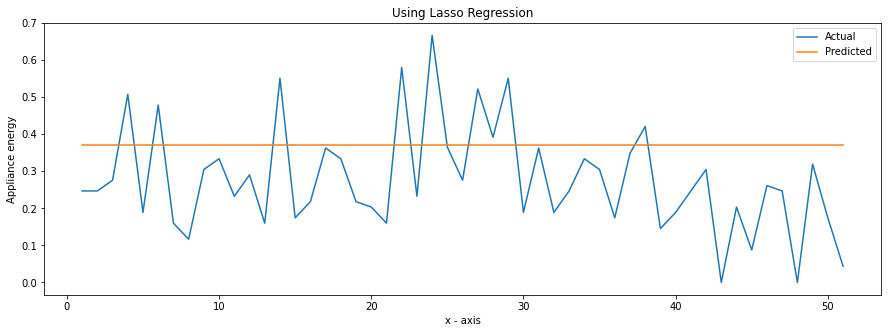

In [ ]:
# Call Lasso Regression model
prediction, MSE['LassoRegression'], MAE['LassoRegression'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression method: " + str(MSE['LassoRegression']))
print("MAE for Lasso Regression method: " + str(MAE['LassoRegression']))
plot(test, prediction, 'Using Lasso Regression','Lasso Regression.png')

     var1(t-24)  var1(t-23)  var1(t-22)  ...  var4(t+11)  var5(t+11)  var6(t+11)
24     1.000000    0.274337    0.273975  ...    0.998178    0.982643    0.892882
25     0.274337    0.273975    0.273798  ...    0.998298    0.982717    0.892330
26     0.273975    0.273798    0.273962  ...    0.998501    0.982814    0.892124
27     0.273798    0.273962    0.274319  ...    0.999154    0.982908    0.891534
28     0.273962    0.274319    0.274072  ...    0.999588    0.982990    0.891596
..          ...         ...         ...  ...         ...         ...         ...
150    0.272710    0.273243    0.273229  ...    0.000000    0.000000    0.000000
151    0.273243    0.273229    0.273524  ...    0.000000    0.000000    0.000000
152    0.273229    0.273524    0.273003  ...    0.000000    0.000000    0.000000
153    0.273524    0.273003    0.272878  ...    0.000000    0.000000    0.000000
154    0.273003    0.272878    0.272731  ...    0.000000    0.000000    0.000000

[131 rows x 216 columns]
(9

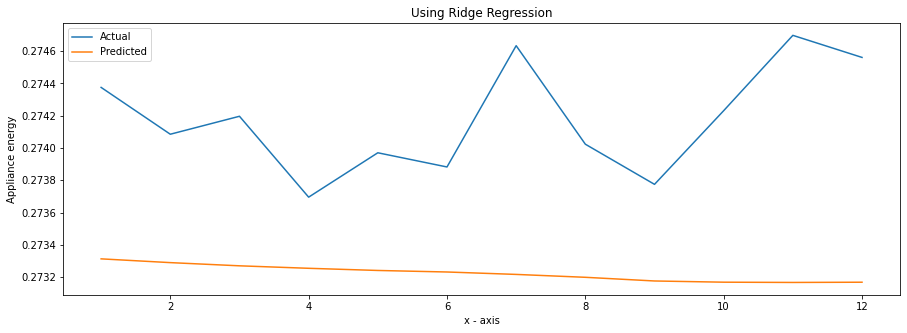

In [ ]:
# Call Ridge Regression model
prediction, MSE['RidgeRegression'], MAE['RidgeRegression'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression method: " + str(MSE['RidgeRegression']))
print("MAE for Ridge Regression method: " + str(MAE['RidgeRegression']))
plot(test[-13], prediction[-13], 'Using Ridge Regression','Ridge Regression.png')

In [ ]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Linear regression PSO call
mse, n_lag = LinearRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)

NameError: ignored

     var1(t-24)  var1(t-23)  var1(t-22)  ...  var4(t+11)  var5(t+11)  var6(t+11)
24     1.000000    0.274337    0.273975  ...    0.998178    0.982643    0.892882
25     0.274337    0.273975    0.273798  ...    0.998298    0.982717    0.892330
26     0.273975    0.273798    0.273962  ...    0.998501    0.982814    0.892124
27     0.273798    0.273962    0.274319  ...    0.999154    0.982908    0.891534
28     0.273962    0.274319    0.274072  ...    0.999588    0.982990    0.891596
..          ...         ...         ...  ...         ...         ...         ...
150    0.272710    0.273243    0.273229  ...    0.000000    0.000000    0.000000
151    0.273243    0.273229    0.273524  ...    0.000000    0.000000    0.000000
152    0.273229    0.273524    0.273003  ...    0.000000    0.000000    0.000000
153    0.273524    0.273003    0.272878  ...    0.000000    0.000000    0.000000
154    0.273003    0.272878    0.272731  ...    0.000000    0.000000    0.000000

[131 rows x 216 columns]
(9

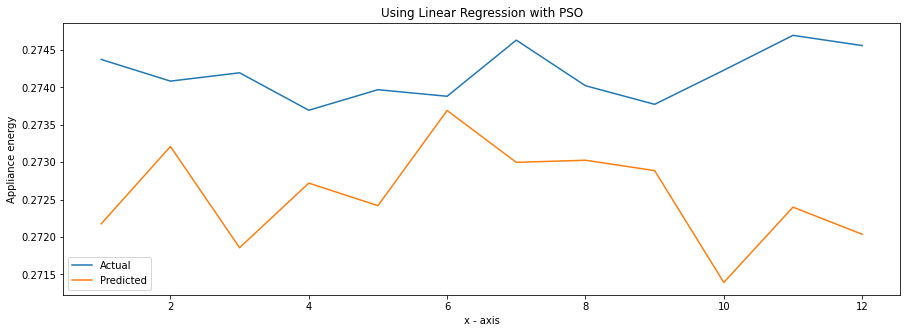

In [ ]:
# Use Result from Linear Regression with PSO method
prediction, MSE['LinearRegPSO'], MAE['LinearRegPSO'], test = LinearReg(scaled, n_lag, n_features,0)
print("MSE for Linear Regression with PSO method: " + str(MSE['LinearRegPSO']))
print("MAE for Linear Regression with PSO method: " + str(MAE['LinearRegPSO']))
plot(test[-13], prediction[-13], 'Using Linear Regression with PSO','Linear Regression with PSO.png')

In [ ]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Gausian-PSO method
mse, n_lag = SVM_Gausian_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)


USING PSO
int64
     var1(t-8)  var1(t-7)  var1(t-6)  ...  var4(t+11)  var5(t+11)  var6(t+11)
11    0.273798   0.273962   0.274319  ...    0.997624    0.982438    0.893483
12    0.273962   0.274319   0.274072  ...    0.997632    0.982453    0.893451
13    0.274319   0.274072   0.274553  ...    0.997632    0.982418    0.893459
14    0.274072   0.274553   0.274912  ...    0.997624    0.982418    0.893467
15    0.274553   0.274912   0.274871  ...    0.997626    0.982418    0.893459
..         ...        ...        ...  ...         ...         ...         ...
150   0.274375   0.274085   0.274196  ...    0.000000    0.000000    0.000000
151   0.274085   0.274196   0.273695  ...    0.000000    0.000000    0.000000
152   0.274196   0.273695   0.273970  ...    0.000000    0.000000    0.000000
153   0.273695   0.273970   0.273882  ...    0.000000    0.000000    0.000000
154   0.273970   0.273882   0.274633  ...    0.000000    0.000000    0.000000

[144 rows x 114 columns]
(95, 42) 95 (95, 12)


ValueError: ignored

(1359, 34) 1359 (1359,)
MSE for SVM_Gausian with PSO method: 0.0011298312975256005
MAE for SVM_Gausian with PSO method: 0.026132367469866455


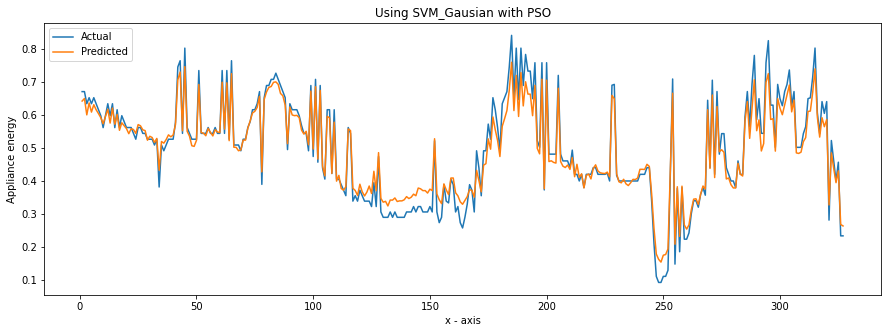

In [ ]:
# Use Result from SVM-Gausian with PSO method
prediction, MSE['SVM_Gausian_PSO'], MAE['SVM_Gausian_PSO'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian with PSO method: " + str(MSE['SVM_Gausian_PSO']))
print("MAE for SVM_Gausian with PSO method: " + str(MAE['SVM_Gausian_PSO']))
plot(test, prediction, 'Using SVM_Gausian with PSO','SVM_Gausian_PSO.png')


USING PSO
int64
(1359, 75) 1359 (1359,)
(1359, 69) 1359 (1359,)
(1359, 69) 1359 (1359,)
(1359, 87) 1359 (1359,)
(1359, 50) 1359 (1359,)
(1359, 37) 1359 (1359,)
(1359, 27) 1359 (1359,)
(1359, 21) 1359 (1359,)
(1359, 22) 1359 (1359,)
(1359, 36) 1359 (1359,)
Iteration: 1 ; Bestposition = [8 1 2 4 5 1]  Bestcost = 0.0011059341372754402
(1359, 14) 1359 (1359,)
(1359, 13) 1359 (1359,)
(1359, 15) 1359 (1359,)
(1359, 17) 1359 (1359,)
(1359, 31) 1359 (1359,)
Iteration: 2 ; Bestposition = [2 1 1 1 9 1]  Bestcost = 0.0010618617754224236
(1359, 10) 1359 (1359,)
(1359, 12) 1359 (1359,)
(1359, 18) 1359 (1359,)
(1359, 46) 1359 (1359,)
(1359, 24) 1359 (1359,)
Iteration: 3 ; Bestposition = [2 1 1 1 9 1]  Bestcost = 0.0010618617754224236
(1359, 15) 1359 (1359,)
(1359, 31) 1359 (1359,)
(1359, 14) 1359 (1359,)
(1359, 52) 1359 (1359,)
(1359, 11) 1359 (1359,)
Iteration: 4 ; Bestposition = [2 1 1 1 9 1]  Bestcost = 0.0010618617754224236
(1359, 29) 1359 (1359,)
(1359, 32) 1359 (1359,)
(1359, 11) 1359 (1359,)

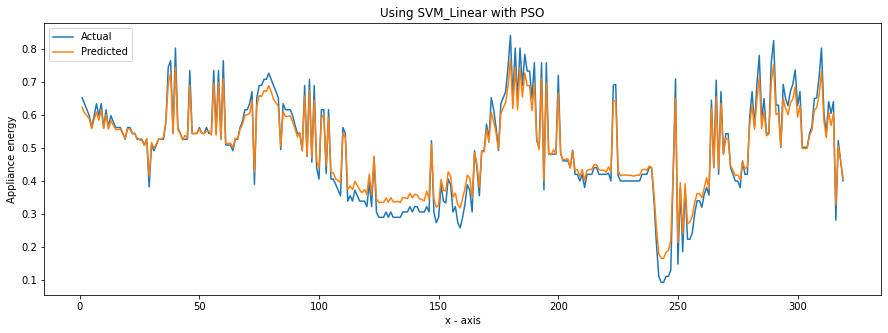

In [ ]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Linear-PSO method
mse, n_lag = SVM_Linear_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from SVM-Linear with PSO method
prediction, MSE['SVM_Linear_PSO'], MAE['SVM_Linear_PSO'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear with PSO method: " + str(MSE['SVM_Linear_PSO']))
print("MAE for SVM_Linear with PSO method: " + str(MAE['SVM_Linear_PSO']))
plot(test, prediction, 'Using SVM_Linear with PSO','SVM_Linear_PSO.png')


USING PSO
int64
(1359, 54) 1359 (1359,)
(1359, 61) 1359 (1359,)
(1359, 61) 1359 (1359,)
(1359, 69) 1359 (1359,)
(1359, 75) 1359 (1359,)
(1359, 52) 1359 (1359,)
(1359, 52) 1359 (1359,)
(1359, 36) 1359 (1359,)
(1359, 59) 1359 (1359,)
(1359, 32) 1359 (1359,)
Iteration: 1 ; Bestposition = [ 4  9 14  1  3  1]  Bestcost = 0.020407693
(1359, 34) 1359 (1359,)
(1359, 48) 1359 (1359,)
(1359, 18) 1359 (1359,)
(1359, 53) 1359 (1359,)
(1359, 28) 1359 (1359,)
Iteration: 2 ; Bestposition = [10  1 20  1  1  1]  Bestcost = 0.012713892
(1359, 35) 1359 (1359,)
(1359, 54) 1359 (1359,)
(1359, 26) 1359 (1359,)
(1359, 37) 1359 (1359,)
(1359, 40) 1359 (1359,)
Iteration: 3 ; Bestposition = [10  1 20  1  1  1]  Bestcost = 0.012713892
(1359, 33) 1359 (1359,)
(1359, 60) 1359 (1359,)
(1359, 33) 1359 (1359,)
(1359, 41) 1359 (1359,)
(1359, 50) 1359 (1359,)
Iteration: 4 ; Bestposition = [10  1 20  1  1  1]  Bestcost = 0.012713892
(1359, 34) 1359 (1359,)
(1359, 36) 1359 (1359,)
(1359, 29) 1359 (1359,)
(1359, 46) 1359

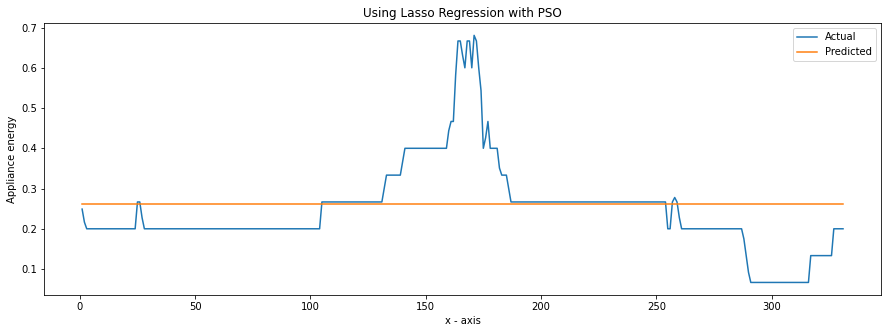

In [ ]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = LassoRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['LassoRegPSO'], MAE['LassoRegPSO'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression with PSO method: " + str(MSE['LassoRegPSO']))
print("MAE for Lasso Regression with PSO method: " + str(MAE['LassoRegPSO']))
plot(test, prediction, 'Using Lasso Regression with PSO','Lasso Regression with PSO.png')


USING PSO
int64
     var1(t-8)  var1(t-7)  var1(t-6)  ...  var4(t+11)  var5(t+11)  var6(t+11)
18    0.274374   0.274634   0.274199  ...    0.997626    0.982418    0.893467
19    0.274634   0.274199   0.274361  ...    0.997644    0.982418    0.893491
20    0.274199   0.274361   0.274631  ...    0.997760    0.982418    0.893717
21    0.274361   0.274631   0.273873  ...    0.997872    0.982418    0.893588
22    0.274631   0.273873   0.273875  ...    0.998000    0.982471    0.893318
..         ...        ...        ...  ...         ...         ...         ...
150   0.274375   0.274085   0.274196  ...    0.000000    0.000000    0.000000
151   0.274085   0.274196   0.273695  ...    0.000000    0.000000    0.000000
152   0.274196   0.273695   0.273970  ...    0.000000    0.000000    0.000000
153   0.273695   0.273970   0.273882  ...    0.000000    0.000000    0.000000
154   0.273970   0.273882   0.274633  ...    0.000000    0.000000    0.000000

[137 rows x 137 columns]
(95, 65) 95 (95, 12)


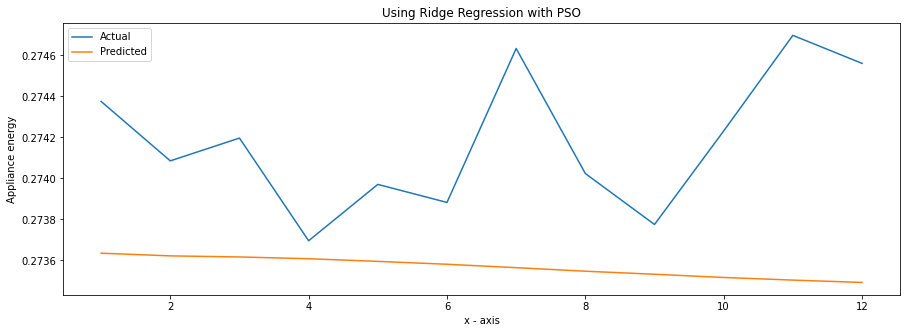

In [ ]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = RidgeRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['RidgeRegPSO'], MAE['RidgeRegPSO'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression with PSO method: " + str(MSE['RidgeRegPSO']))
print("MAE for Ridge Regression with PSO method: " + str(MAE['RidgeRegPSO']))
plot(test[-13], prediction[-13], 'Using Ridge Regression with PSO','Ridge Regression with PSO.png')

Streaming output truncated to the last 5000 lines.
     var1(t-3)  var1(t-2)  var1(t-1)  ...  var4(t+11)  var5(t+11)  var6(t+11)
8     0.274319   0.274072   0.274553  ...    0.997626    0.982288    0.893813
9     0.274072   0.274553   0.274912  ...    0.997629    0.982298    0.893684
10    0.274553   0.274912   0.274871  ...    0.997626    0.982377    0.893629
11    0.274912   0.274871   0.274374  ...    0.997624    0.982438    0.893483
12    0.274871   0.274374   0.274634  ...    0.997632    0.982453    0.893451
..         ...        ...        ...  ...         ...         ...         ...
150   0.273882   0.274633   0.274023  ...    0.000000    0.000000    0.000000
151   0.274633   0.274023   0.273775  ...    0.000000    0.000000    0.000000
152   0.274023   0.273775   0.274231  ...    0.000000    0.000000    0.000000
153   0.273775   0.274231   0.274697  ...    0.000000    0.000000    0.000000
154   0.274231   0.274697   0.274561  ...    0.000000    0.000000    0.000000

[147 rows x 

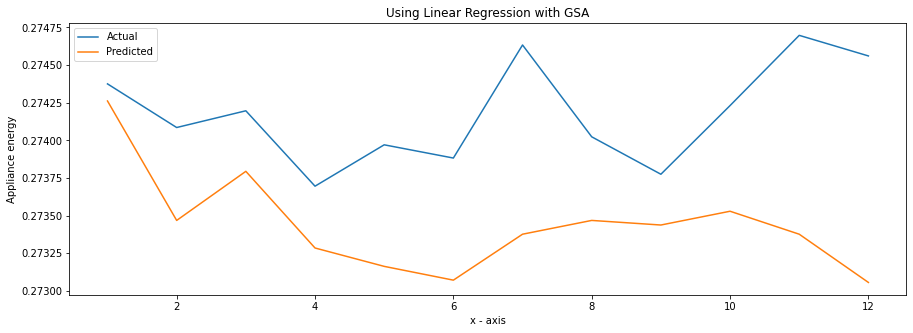

In [ ]:
# GSA Parameters
import sys
m=20
maxI=10
npop=5
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Linear Regression GSA method
mse, n_lag = LinearRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Linear Regression with GSA method
prediction, MSE['LinearRegGSA'], MAE['LinearRegGSA'], test = LinearReg(scaled, n_lag, n_features,0)
print("MSE for Linear Regression with GSA method: " + str(MSE['LinearRegGSA']))
print("MAE for Linear Regression with GSA method: " + str(MAE['LinearRegGSA']))
plot(test[-13], prediction[-13], 'Using Linear Regression with GSA','Linear Regression with GSA.png')


USING GSA
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
(1359, 77) 1359 (1359,)
Iteration: 0 ; Bestposition = [ 3 17 19 12 12 14]  Bestcost = 0.0031118877322376193
(1359, 77) 1359 (1359,)
MSE for SVM_Gausian with GSA method: 0.0031118877322376193
MAE for SVM_Gausian with GSA method: 0.04347129401723607


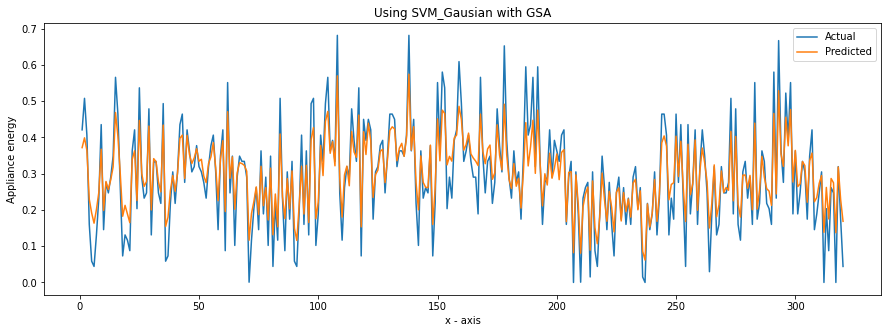

In [ ]:
# GSA Parameters
m=20
maxI=1
npop=1
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call SVM Gausian GSA method
mse, n_lag = SVM_Gausian_GSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from SVM-Gausian with GSA method
prediction, MSE['SVM_Gausian_GSA'], MAE['SVM_Gausian_GSA'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian with GSA method: " + str(MSE['SVM_Gausian_GSA']))
print("MAE for SVM_Gausian with GSA method: " + str(MAE['SVM_Gausian_GSA']))
plot(test, prediction, 'Using SVM_Gausian with GSA','SVM_Gausian_GSA.png')


USING GSA
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
Iteration: 0 ; Bestposition = [ 3  2  1  1 18 17]  Bestcost = 0.0020247989073503506
(1359, 42) 1359 (1359,)
MSE for SVM_Linear with GSA method: 0.0020247989073503506
MAE for SVM_Linear with GSA method: 0.03520946382520141


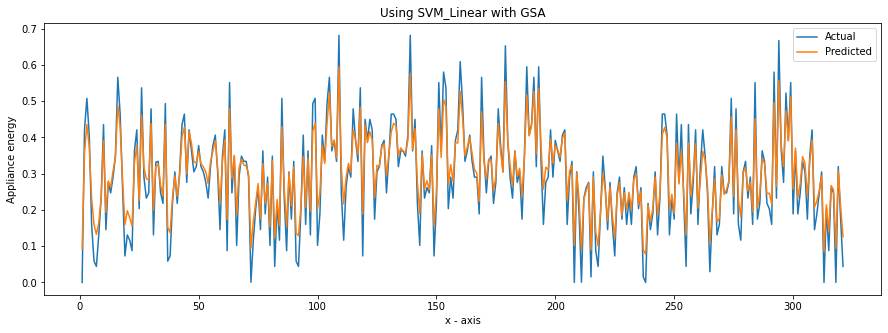

In [ ]:
# GSA Parameters
m=20
maxI=1
npop=1
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call SVM Linear GSA method
mse, n_lag = SVM_Linear_GSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from SVM-Linear with GSA method
prediction, MSE['SVM_Linear_GSA'], MAE['SVM_Linear_GSA'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear with GSA method: " + str(MSE['SVM_Linear_GSA']))
print("MAE for SVM_Linear with GSA method: " + str(MAE['SVM_Linear_GSA']))
plot(test, prediction, 'Using SVM_Linear with GSA','SVM_Linear_GSA.png')


USING GSA
(1359, 42) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
Iteration: 0 ; Bestposition = [ 9 17 14 10 19 17]  Bestcost = 0.026695454
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 42) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(1359, 86) 1359 (1359,)
(13

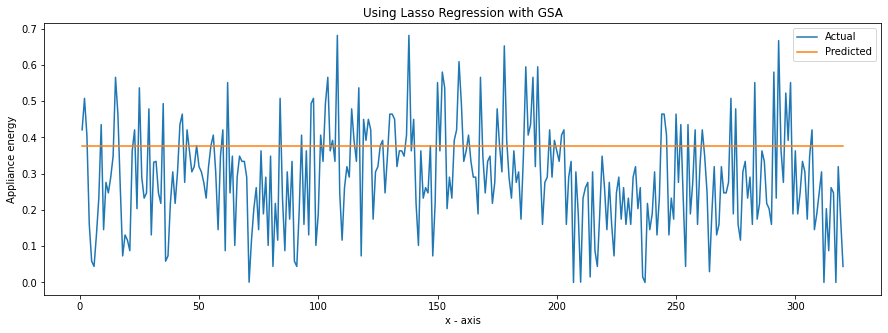

In [ ]:
# GSA Parameters
import sys
m=20
maxI=5
npop=2
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Lasso Regression GSA method
mse, n_lag = LassoRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Lasso Regression with GSA method
prediction, MSE['LassoRegGSA'], MAE['LassoRegGSA'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression with GSA method: " + str(MSE['LassoRegGSA']))
print("MAE for Lasso Regression with GSA method: " + str(MAE['LassoRegGSA']))
plot(test, prediction, 'Using Lasso Regression with GSA','Lasso Regression with GSA.png')

Streaming output truncated to the last 5000 lines.
     var1(t-5)  var1(t-4)  var1(t-3)  ...  var4(t+11)  var5(t+11)  var6(t+11)
11    0.274072   0.274553   0.274912  ...    0.997624    0.982438    0.893483
12    0.274553   0.274912   0.274871  ...    0.997632    0.982453    0.893451
13    0.274912   0.274871   0.274374  ...    0.997632    0.982418    0.893459
14    0.274871   0.274374   0.274634  ...    0.997624    0.982418    0.893467
15    0.274374   0.274634   0.274199  ...    0.997626    0.982418    0.893459
..         ...        ...        ...  ...         ...         ...         ...
150   0.273695   0.273970   0.273882  ...    0.000000    0.000000    0.000000
151   0.273970   0.273882   0.274633  ...    0.000000    0.000000    0.000000
152   0.273882   0.274633   0.274023  ...    0.000000    0.000000    0.000000
153   0.274633   0.274023   0.273775  ...    0.000000    0.000000    0.000000
154   0.274023   0.273775   0.274231  ...    0.000000    0.000000    0.000000

[144 rows x 

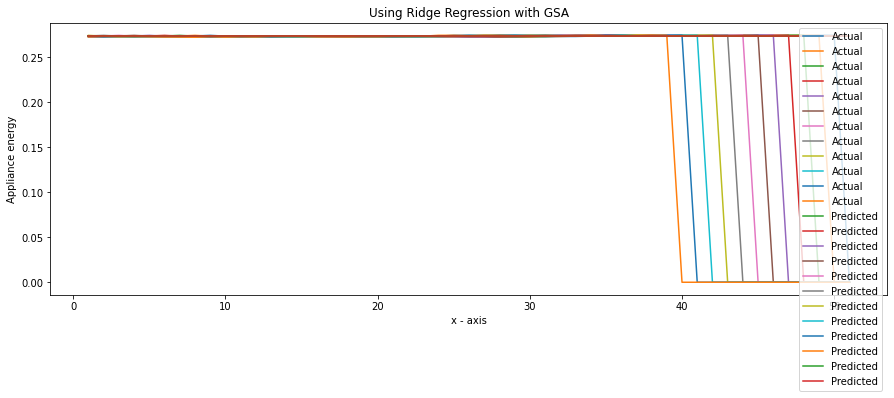

In [ ]:
# GSA Parameters
import sys
m=20
maxI=10
npop=5
eps=sys.float_info.epsilon
e=0.0000001
g0=10
alpha=random.uniform(0,1)
# Call Ridge Regression GSA method
mse, n_lag = RidgeRegGSA(scaled,maxI,npop,g0,alpha,e,eps,n_features,m)
# Use Result from Ridge Regression with GSA method
prediction, MSE['RidgeRegGSA'], MAE['RidgeRegGSA'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression with GSA method: " + str(MSE['RidgeRegGSA']))
print("MAE for Ridge Regression with GSA method: " + str(MAE['RidgeRegGSA']))
plot(test[-13], prediction[-13], 'Using Ridge Regression with GSA','Ridge Regression with GSA.png')

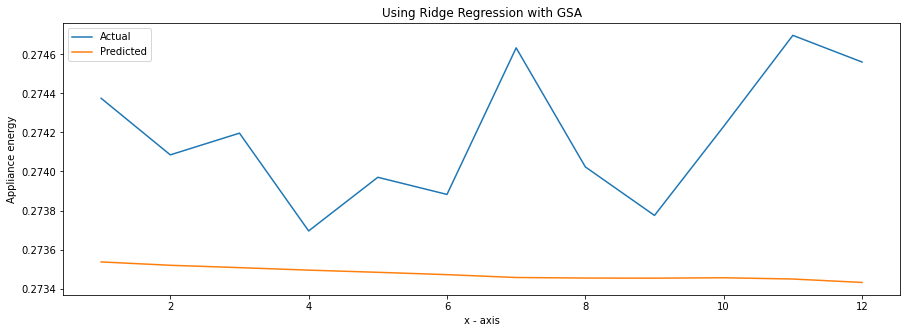

In [ ]:
plot(test[-13], prediction[-13], 'Using Ridge Regression with GSA','Ridge Regression with GSA.png')

In [ ]:
prediction

array([[0.2735365 , 0.27351925, 0.27350724, 0.27349442, 0.27348325,
        0.27347133, 0.27345666, 0.2734538 , 0.27345327, 0.27345544,
        0.27344897, 0.27343142],
       [0.27353653, 0.27351925, 0.27350724, 0.27349442, 0.27348325,
        0.27347133, 0.2734567 , 0.27345383, 0.27345327, 0.27345544,
        0.27344897, 0.27343142],
       [0.27353653, 0.27351928, 0.27350727, 0.27349445, 0.27348328,
        0.27347133, 0.2734567 , 0.27345383, 0.2734533 , 0.27345547,
        0.27344897, 0.27343145],
       [0.27353656, 0.27351928, 0.27350727, 0.27349445, 0.27348328,
        0.27347136, 0.27345672, 0.27345386, 0.2734533 , 0.27345547,
        0.27344897, 0.27343145],
       [0.27353653, 0.27351925, 0.27350727, 0.27349445, 0.27348328,
        0.27347133, 0.2734567 , 0.27345383, 0.2734533 , 0.27345547,
        0.27344897, 0.27343142],
       [0.27353653, 0.27351925, 0.27350727, 0.27349445, 0.27348328,
        0.27347133, 0.2734567 , 0.27345383, 0.2734533 , 0.27345547,
        0.27344897,

In [ ]:
methods = ["LinearRegression","SVM_Gausian","SVM_Linear","LassoRegression","RidgeRegression","LinearRegPSO","SVM_Gausian_PSO","SVM_Linear_PSO","LassoRegPSO","RidgeRegPSO","LinearRegGSA","SVM_Gausian_GSA","SVM_Linear_GSA","LassoRegGSA","RidgeRegGSA"]
print(methods)
print(MSE)
print(MAE)

['LinearRegression', 'SVM_Gausian', 'SVM_Linear', 'LassoRegression', 'RidgeRegression', 'LinearRegPSO', 'SVM_Gausian_PSO', 'SVM_Linear_PSO', 'LassoRegPSO', 'RidgeRegPSO', 'LinearRegGSA', 'SVM_Gausian_GSA', 'SVM_Linear_GSA', 'LassoRegGSA', 'RidgeRegGSA']
{'LinearRegression': 7.079408e-05, 'SVM_Gausian': 0.012296669979617621, 'SVM_Linear': 0.008615110389668067, 'LassoRegression': 0.02905112, 'RidgeRegression': 0.0005036287, 'LinearRegPSO': 5.550593e-15, 'SVM_Gausian_PSO': 0.0011298312975256005, 'SVM_Linear_PSO': 0.0009722767709825601, 'LassoRegPSO': 0.012373173, 'RidgeRegPSO': 2.2399787e-05, 'LinearRegGSA': 3.4166863e-15, 'SVM_Gausian_GSA': 0.0031118877322376193, 'SVM_Linear_GSA': 0.0020247989073503506, 'LassoRegGSA': 0.026695454, 'RidgeRegGSA': 3.3405075e-05}
{'LinearRegression': 0.0073971786, 'SVM_Gausian': 0.08731647250863653, 'SVM_Linear': 0.0717453938438555, 'LassoRegression': 0.14545971, 'RidgeRegression': 0.0188668, 'LinearRegPSO': 5.6171306e-08, 'SVM_Gausian_PSO': 0.0261323674698

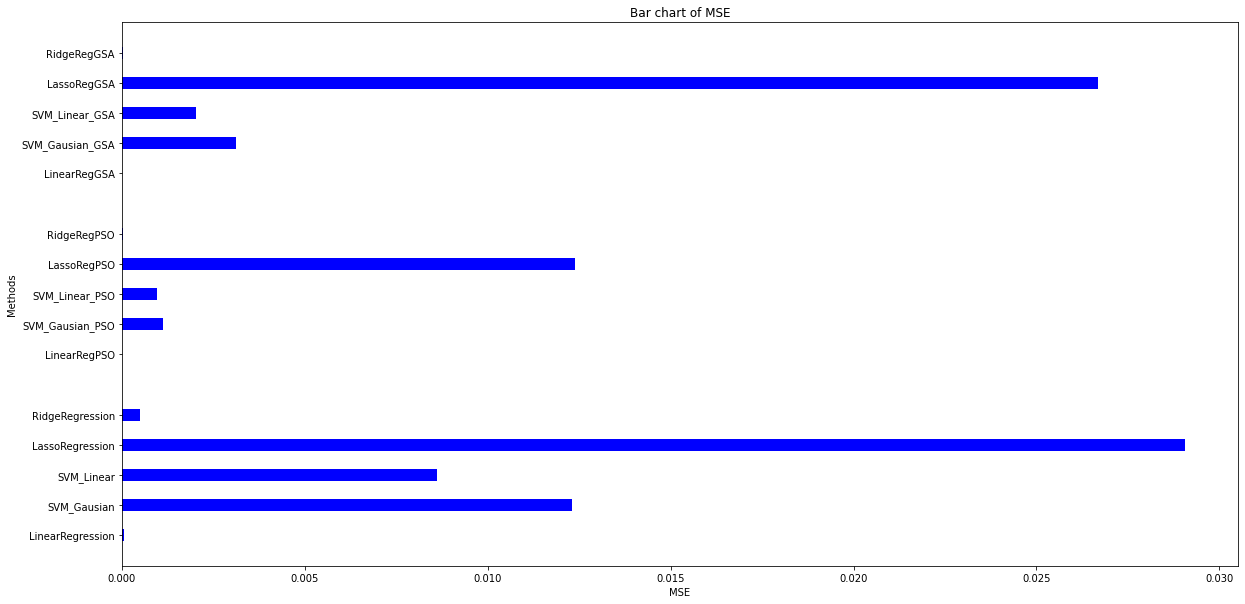

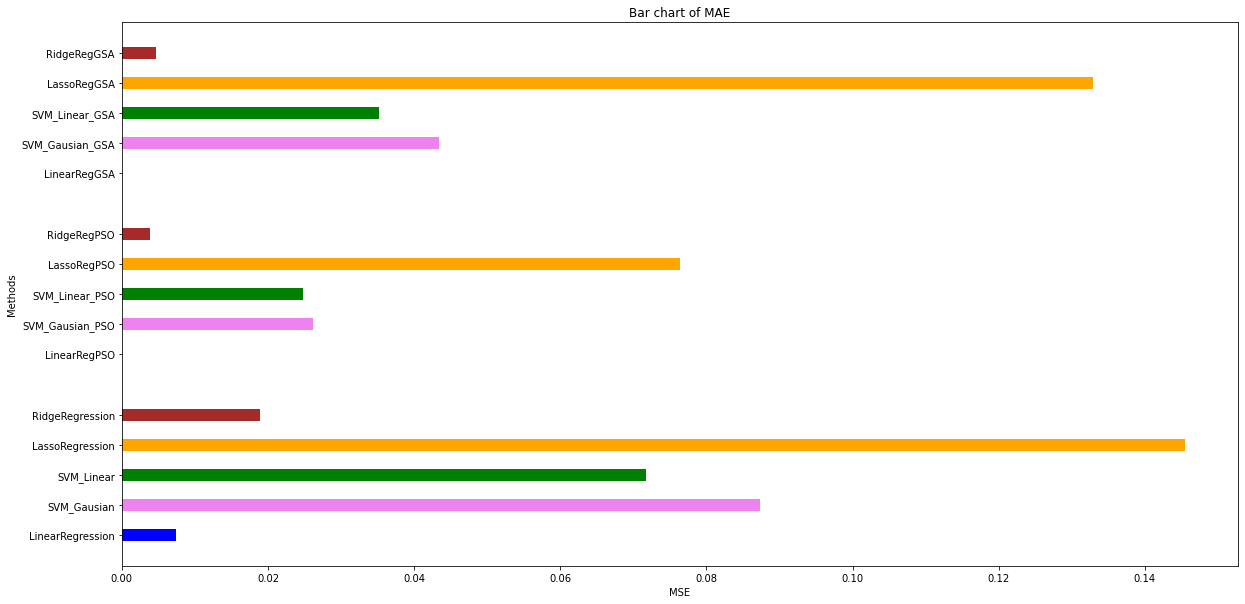

In [ ]:
performance = []
for i in range(0,15):
    performance.append(MSE[methods[i]])
    

# x-coordinates of left sides of bars  
left = [1, 3, 5, 7, 9, 13, 15, 17, 19, 21, 25, 27, 29, 31,33] 
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 10]
plt.barh(left, performance, tick_label = methods, color = ['blue']) 
  
# naming the y-axis 
plt.ylabel('Methods') 
# naming the x-axis 
plt.xlabel('MSE') 
# plot title 
plt.title('Bar chart of MSE') 
# function to show the plot 
plt.savefig('MSE.png',dpi=1200)
plt.show() 

for i in range(0,15):
    performance[i]=MAE[methods[i]]
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 10]
plt.barh(left, performance, tick_label = methods, color = ['blue', 'violet', 'green', 'orange', 'brown']) 
# naming the y-axis 
plt.ylabel('Methods') 
# naming the x-axis 
plt.xlabel('MSE') 
# plot title 
plt.title('Bar chart of MAE') 
# function to show the plot
plt.savefig('MAE.png',dpi=1200)
plt.show() 
